In [137]:
!pwd


/Users/macbook/divtel/MST


In [138]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import sys
from ipywidgets import interactive, FloatSlider, interact, fixed
from divtel import *
from adjustText import adjust_text

import copy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroplan.plots import plot_sky
from astroplan import FixedTarget
#from . import utils
#from .const import COLORS
#from . import pointing

from matplotlib.transforms import Affine2D
from astropy.visualization.wcsaxes import SphericalCircle

import healpy as hp
import tqdm

#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The Idea is to have two notebooks, one for MST configuration confronting just one altitude and the other for them changing with zenith
This one should be just for one altitude 

## LOAD CTA CONFIG

In [139]:
cta = CTA_Info('south')

Observer         :  CTA South
Location         :  Paranal , (1946.635798, -5467.63394562, -2642.49852123) km
Observation time :  2025-02-24T10:43:06.697


In [140]:
# Note that if the radius is in meters, 
# you can set LoadConfig(file, radius="meters")
# defalut is in degrees

array = LoadConfig("/Users/macbook/divtel/ParanalArrayPositions_divProd6.txt", frame=cta)
full_array= LoadConfig("/Users/macbook/divtel/Paranal_only_MST.txt", frame=cta)

## Check configuration table

In [141]:
array.table.units = "deg"
array.table
full_array.table

<Table length=14>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1     0.0     0.0    24.0   0.000 ...   1.000  -0.000   0.000   22.65
    2     0.0   151.0    25.0   0.000 ...   1.000  -0.000   0.000  152.67
    3     0.0  -151.0    31.0   0.000 ...   1.000  -0.000   0.000  152.68
    4   150.0    75.0    21.0   0.000 ...   1.000  -0.000   0.000  188.09
    5   150.0   -75.0    26.0   0.000 ...   1.000  -0.000   0.000  187.98
    6   150.0   240.0    24.0   0.000 ...   1.000  -0.000   0.000  295.50
    7   150.0  -240.0    30.0   0.000 ...   1.000  -0.000   0.000  295.49
    8   313.0     0.0    19.0   0.000 ...   1.000  -0.000   0.000  335.47
    9  -150.0   -75.0    28.0   0.000 ...   1.000  -0.000   0.000  148.05
   10  -150.0    75.0    28.0   0.000 ...   1.000  -0.000   0.000  148.05
   11  -150.0  -240.0    38.5   0.000 ...   1.000  -0.000   0.000  272.05
   12  -150.0   240.0    27.0   0.000 ...   1.000  -0.000   0.000  271.83
   13  -313.0  -162.0    35.0   0.000 ...   1.000  -0.000   0.000  332.82
   14  -313.0   162.0    30.5   0.000 ...   1.000  -0.000   0.000  332.75

In [142]:
table=array.table

## Check the telescope spatial distribution
This is useful to pick the groups

In [143]:
array.table

<Table length=64>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1   -20.0   -65.0    34.0   0.000 ...   1.000  -0.000   0.000   66.52
    2    80.0     0.0    29.0   0.000 ...   1.000  -0.000   0.000   86.67
    3   -20.0    65.0    31.0   0.000 ...   1.000  -0.000   0.000   66.37
    4  -120.0     0.0    33.0   0.000 ...   1.000  -0.000   0.000  113.39
    5     0.0     0.0    24.0   0.000 ...   1.000  -0.000   0.000    8.55
    6     0.0   151.0    25.0   0.000 ...   1.000  -0.000   0.000  151.21
    7     0.0  -151.0    31.0   0.000 ...   1.000  -0.000   0.000  151.16
    8   150.0    75.0    21.0   0.000 ...   1.000  -0.000   0.000  173.90
    9   150.0   -75.0    26.0   0.000 ...   1.000  -0.000   0.000  173.73
  ...     ...     ...     ...     ... ...     ...     ...     ...     ...
   56   748.0   367.0    6.25   0.000 ...   1.000  -0.000   0.000  839.50
   57   816.0  -648.0   41.25   0.000 ...   1.000  -0.000   0.000 1047.30
   58   816.0   648.0   18.75   0.000 ...   1.000  -0.000   0.000 1047.28
   59     0.0  -950.0   75.25   0.000 ...   1.000  -0.000   0.000  951.13
   60     0.0   950.0   28.25   0.000 ...   1.000  -0.000   0.000  950.02
   61  -955.0  -199.0   39.25   0.000 ...   1.000  -0.000   0.000  969.03
   62  -955.0   199.0   22.75   0.000 ...   1.000  -0.000   0.000  969.01
   63   955.0  -199.0    7.75   0.000 ...   1.000  -0.000   0.000  982.28
   64   955.0   199.0    5.25   0.000 ...   1.000  -0.000   0.000  982.34

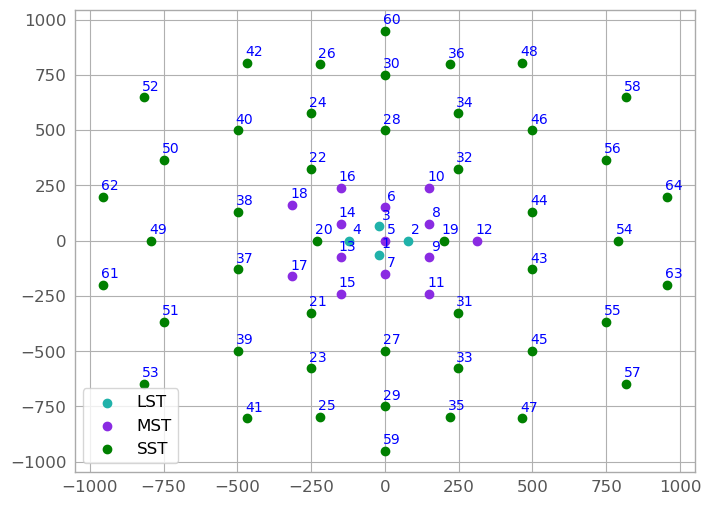

In [144]:
# Loop through all the telescopes
#for fov in array.table["fov"]:
#    print(fov)
colors = [
    'lightseagreen' if np.isclose(fov, 14.5356) else
    'blueviolet' if np.isclose(fov, 46.707) else 
    'green' if np.isclose(fov, 62.462) else
    'red'  # Default color if none of the conditions match
    for fov in array.table["fov"]
]
fov_labels = {
    'lightseagreen': 'LST',
    'blueviolet': 'MST',
    'green': 'SST'
}
for i in range(len(array.table)):
    plt.scatter(array.table['x'][i], array.table['y'][i], c=colors[i], label=fov_labels[colors[i]])

    # Annotate each point with the telescope ID
    #matplotlib.pyplot.annotate(text, xy, xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None, **kwargs)
#Annotate the point xy with text text.
#In the simplest form, the text is placed at xy.
    plt.annotate(str(array.table["id"][i]),
                 (array.table['x'][i], array.table['y'][i]),  # Point position
                 textcoords="offset points",  # Text position relative to the point
                 xytext=(5, 5),  # Offset in pixels (to avoid overlapping the point)
                 ha='center', fontsize=10, color='blue')
handles, labels = plt.gca().get_legend_handles_labels()
#handles, labels like this is doing
    #plt.gca() gets the current Axes object, which is where your plot is
    #.get_legend_handles_labels()
        #handles: Returns a list of the graphical elements (e.g., lines, scatter plot points) that would appear in the legend.
        # labels: Returns the text labels associated with each graphical element in handles

by_label = dict(zip(labels, handles))  # Remove duplicate labels, the dictionary by the structure takes out the double 
plt.legend(by_label.values(), by_label.keys())
#by_label.values This is pulling out the unique graphical elements
# by_label.keys  This is retrieving the unique text 
plt.savefig("./different_telescopes.png", dpi=300, bbox_inches="tight")
plt.show() 

## Check the hyper field of view (hFoV)

This is the whole telescope array hFoV maybe? (ask)

In [145]:
array.hFoV(m_cut=3) 

64it [00:08,  7.34it/s]


(62.238869377690584, 57.415086388537716)

In [146]:
#array.hFoV(m_cut=3)

## Grouping telescopes

In [147]:
sub_groups={'1':[7,8,11], 
            '2': [5,13,16,18],
            '3': [14,15,17], 
            '4': [6,10,12,9]}


In [148]:
def compute_center_of_gravity(group):
    x, y, z = group['x'], group['y'], group['z']
    cog_x = round(np.mean(x),2)
    cog_y = round(np.mean(y),2)
    cog_z = round(np.mean(z),2)
    return cog_x, cog_y, cog_z

# Function to create new telescope list with center of gravity
def create_new_group_list(tel_group):
    new_telescopes = []
    for group in tel_group.groups:
        print(tel_group.groups)
        print (group['focal'][0],round(group['radius'][0],2))
        #id_ = group["id"][0]
        cog = compute_center_of_gravity(group)
        focal, fov = group['focal'][0], round(group['radius'][0],2)  # Assuming same within a group
        new_telescopes.append([*cog, focal, fov])
    return new_telescopes


In [149]:
tel_group, labels, number_of_telescopes_subarray_1 =array.group_by(sub_groups)

In [150]:
# Step 2: Create new telescope list with center of gravity
new_telescopes = create_new_group_list(tel_group)



<TableGroups indices=[ 0 50 53 57 60 64]>
28.0 2.15
<TableGroups indices=[ 0 50 53 57 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 57 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 57 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 57 60 64]>
16.0 3.85


In [151]:
#del new_telescopes[0]# Step 3: Output the result
#for telescope in new_telescopes:
#    print(telescope)
del new_telescopes[0]#No clue why it keeps on putting me an extra telescope...soooo... I deleted it... I will find out why
for telescope in new_telescopes:
    print(telescope)

[100.0, -105.33, 27.33, 16.0, 3.85]
[-153.25, 81.75, 27.38, 16.0, 3.85]
[-204.33, -109.0, 33.83, 16.0, 3.85]
[153.25, 79.0, 23.5, 16.0, 3.85]


In [152]:
# Define the file path where you want to save the output
output_file_path = './MST_chosen_configuration.txt'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path}")


New telescope data has been written to ./MST_chosen_configuration.txt


## SANITY CHECK

In [153]:
#array.table

# THE FIELD OF VIEW

## GRAPHING MULTIPLICITY AND FOV to understand what is going on 

In [154]:
array= LoadConfig("./MST_chosen_configuration.txt", frame=cta, pointing2src=True)


In [155]:
array.table

<Table length=4>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1   100.0 -105.33   27.33   0.000 ...   1.000  -0.000   0.000  156.04
    2 -153.25   81.75   27.38   0.000 ...   1.000  -0.000   0.000  158.82
    3 -204.33  -109.0   33.83   0.000 ...   1.000  -0.000   0.000  202.35
    4  153.25    79.0    23.5   0.000 ...   1.000  -0.000   0.000  201.79

In [156]:
full_array.table

<Table length=14>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1     0.0     0.0    24.0   0.000 ...   1.000  -0.000   0.000   22.65
    2     0.0   151.0    25.0   0.000 ...   1.000  -0.000   0.000  152.67
    3     0.0  -151.0    31.0   0.000 ...   1.000  -0.000   0.000  152.68
    4   150.0    75.0    21.0   0.000 ...   1.000  -0.000   0.000  188.09
    5   150.0   -75.0    26.0   0.000 ...   1.000  -0.000   0.000  187.98
    6   150.0   240.0    24.0   0.000 ...   1.000  -0.000   0.000  295.50
    7   150.0  -240.0    30.0   0.000 ...   1.000  -0.000   0.000  295.49
    8   313.0     0.0    19.0   0.000 ...   1.000  -0.000   0.000  335.47
    9  -150.0   -75.0    28.0   0.000 ...   1.000  -0.000   0.000  148.05
   10  -150.0    75.0    28.0   0.000 ...   1.000  -0.000   0.000  148.05
   11  -150.0  -240.0    38.5   0.000 ...   1.000  -0.000   0.000  272.05
   12  -150.0   240.0    27.0   0.000 ...   1.000  -0.000   0.000  271.83
   13  -313.0  -162.0    35.0   0.000 ...   1.000  -0.000   0.000  332.82
   14  -313.0   162.0    30.5   0.000 ...   1.000  -0.000   0.000  332.75

In [157]:
array.table

<Table length=4>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1   100.0 -105.33   27.33   0.000 ...   1.000  -0.000   0.000  156.04
    2 -153.25   81.75   27.38   0.000 ...   1.000  -0.000   0.000  158.82
    3 -204.33  -109.0   33.83   0.000 ...   1.000  -0.000   0.000  202.35
    4  153.25    79.0    23.5   0.000 ...   1.000  -0.000   0.000  201.79

In [158]:
full_array.divergent_pointing(0.02, az=0,alt=70)

In [159]:
full_array.hFoV(m_cut=3)[0]

14it [00:01,  7.22it/s]


73.59556151445419

In [160]:
full_array.hFoV()[0]

14it [00:01,  7.45it/s]


154.78410772542816

14it [00:01,  7.47it/s]
14it [00:01,  7.21it/s]


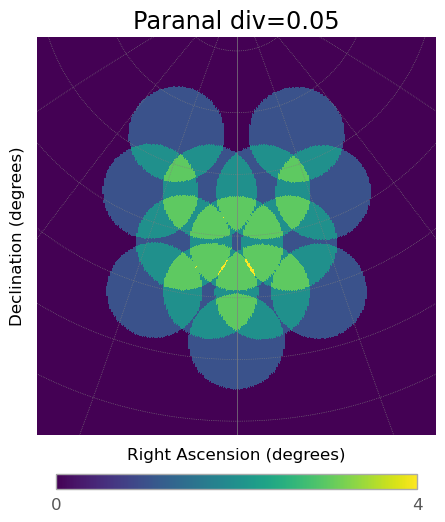

In [161]:
full_array.divergent_pointing(0.05, az=0,alt=70)
full_array.multiplicity_plot()

-6.283185307179586 rad
-6.278767501221106 rad
-0.004417805958480514 rad
-6.280981349736347 rad
-0.002203957443239535 rad
-6.27613274887233 rad
-0.007052558307256707 rad
-6.283185307179586 rad
-0.0021846975524240086 rad
-6.281000609627162 rad
-0.006990929398609236 rad
-6.2761943777809766 rad
-0.0046966195813640255 rad
-6.278488687598222 rad


14it [00:01,  7.30it/s]
14it [00:01,  7.07it/s]


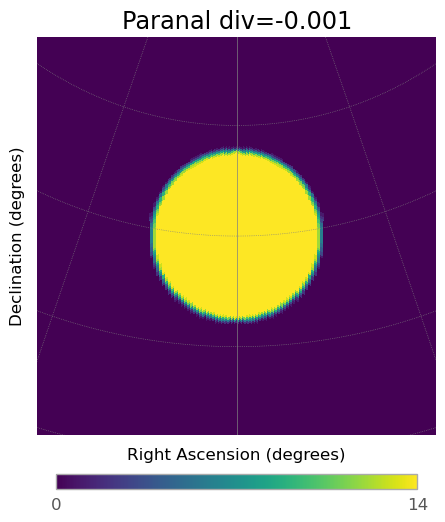

In [162]:
full_array.divergent_pointing(-0.001, az=0,alt=70)
full_array.multiplicity_plot()

-626.0 -626.0 51.24
-626.0 -626.0 1303.24
-626.0 626.0 51.24
-626.0 626.0 1303.24
626.0 -626.0 51.24
626.0 -626.0 1303.24
626.0 626.0 51.24
626.0 626.0 1303.24


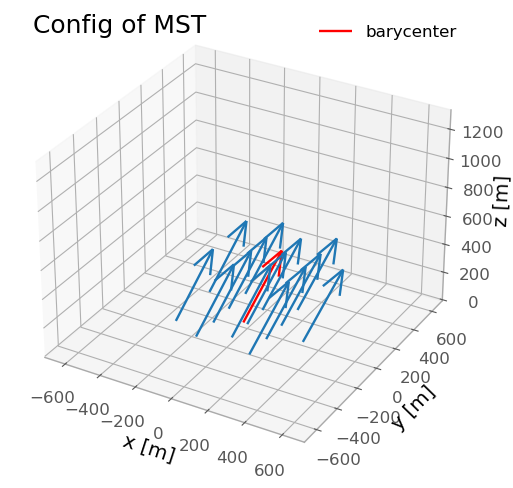

In [163]:
#array_alt_1.display("xyz")
#This is just to see that that everything is working like it should
ax = full_array.display("xyz")



#ax.legend(by_label.values(), by_label.keys(), loc='lower left')
ax.text2D(0.05, 0.95, "Config of MST ", 
          transform=ax.transAxes, fontsize=18)



plt.show()

In [164]:
div=[]

div=np.linspace(0,0.1, 40)
div_no_saturation_full_array=[]#So we can get an array with all the divergence in the full_array
div_no_saturation_sub_1=[]
div_no_saturation_sub_2=[]
div_no_saturation_sub_3=[]


In [165]:
FoV_full_array=[]
multiplicity_full_array=[]
for divergence in div:
    full_array.divergent_pointing(divergence, az=0,alt=70)
    if full_array.hFoV(m_cut=3)[0] != 0: #To get the no saturation, because what happens is that when it looses focus due to the separation, we will just get 0 FoV
        FoV=full_array.hFoV(m_cut=3)[0]
        multiplicity=full_array.hFoV(m_cut=3)[1]
        FoV_full_array.append(FoV)
        multiplicity_full_array.append(multiplicity)
        div_no_saturation_full_array.append(divergence)

14it [00:01,  7.39it/s]
14it [00:01,  7.32it/s]
14it [00:01,  7.28it/s]
14it [00:01,  7.36it/s]
14it [00:01,  7.37it/s]
14it [00:01,  7.33it/s]
14it [00:01,  7.15it/s]
14it [00:01,  7.19it/s]
14it [00:01,  7.38it/s]
14it [00:01,  7.37it/s]
14it [00:01,  7.34it/s]
14it [00:01,  7.13it/s]
14it [00:01,  7.42it/s]
14it [00:01,  7.39it/s]
14it [00:01,  7.32it/s]
14it [00:01,  7.37it/s]
14it [00:01,  7.32it/s]
14it [00:01,  7.37it/s]
14it [00:01,  7.35it/s]
14it [00:01,  7.28it/s]
14it [00:01,  7.43it/s]
14it [00:01,  7.44it/s]
14it [00:01,  7.39it/s]
14it [00:01,  7.44it/s]
14it [00:01,  7.39it/s]
14it [00:01,  7.43it/s]
14it [00:02,  6.94it/s]
14it [00:01,  7.27it/s]
14it [00:01,  7.32it/s]
14it [00:01,  7.43it/s]
14it [00:01,  7.40it/s]
14it [00:02,  7.00it/s]
14it [00:01,  7.24it/s]
14it [00:01,  7.12it/s]
14it [00:01,  7.25it/s]
14it [00:01,  7.13it/s]
14it [00:01,  7.27it/s]
14it [00:01,  7.39it/s]
14it [00:01,  7.10it/s]
14it [00:01,  7.32it/s]
14it [00:01,  7.35it/s]
14it [00:02,  6.

In [166]:
div_no_saturation_full_array

[0.0,
 0.002564102564102564,
 0.005128205128205128,
 0.007692307692307693,
 0.010256410256410256,
 0.01282051282051282,
 0.015384615384615385,
 0.017948717948717947,
 0.020512820512820513,
 0.023076923076923078,
 0.02564102564102564,
 0.028205128205128206,
 0.03076923076923077,
 0.03333333333333333,
 0.035897435897435895,
 0.038461538461538464,
 0.041025641025641026,
 0.04358974358974359,
 0.046153846153846156,
 0.04871794871794872,
 0.05128205128205128]

In [167]:
array.table

<Table length=4>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1   100.0 -105.33   27.33   0.000 ...   1.000  -0.000   0.000  156.04
    2 -153.25   81.75   27.38   0.000 ...   1.000  -0.000   0.000  158.82
    3 -204.33  -109.0   33.83   0.000 ...   1.000  -0.000   0.000  202.35
    4  153.25    79.0    23.5   0.000 ...   1.000  -0.000   0.000  201.79

In [168]:
FoV_array_complete=[]
multiplicity_array_complete=[]
FoV_array=[]#This will be the one without saturation
multiplicity_array=[] #This will be the one without saturation
for divergence in div:
    array.divergent_pointing(divergence, az=0,alt=70)    
    FoV=array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0]
    multiplicity=array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1]
    FoV_array_complete.append(FoV)
    multiplicity_array_complete.append(multiplicity)
    

4it [00:00,  7.28it/s]
4it [00:00,  7.27it/s]
4it [00:00,  7.30it/s]
4it [00:00,  7.46it/s]
4it [00:00,  7.38it/s]
4it [00:00,  7.25it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.35it/s]
4it [00:00,  7.18it/s]
4it [00:00,  7.10it/s]
4it [00:00,  7.16it/s]
4it [00:00,  7.31it/s]
4it [00:00,  6.70it/s]
4it [00:00,  6.37it/s]
4it [00:00,  7.26it/s]
4it [00:00,  6.83it/s]
4it [00:00,  7.15it/s]
4it [00:00,  7.25it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.33it/s]
4it [00:00,  7.41it/s]
4it [00:00,  7.11it/s]
4it [00:00,  6.60it/s]
4it [00:00,  6.63it/s]
4it [00:00,  7.10it/s]
4it [00:00,  6.44it/s]
4it [00:00,  7.01it/s]
4it [00:00,  7.02it/s]
4it [00:00,  6.95it/s]
4it [00:00,  7.42it/s]
4it [00:00,  7.33it/s]
4it [00:00,  7.36it/s]
4it [00:00,  7.44it/s]
4it [00:00,  7.21it/s]
4it [00:00,  7.36it/s]
4it [00:00,  7.51it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.42it/s]
4it [00:00,  7.58it/s]
4it [00:00,  7.17it/s]
4it [00:00,

In [169]:

FoV_array=[]#This will be the one without saturation
multiplicity_array=[] #This will be the one without saturation
div_no_saturation_sub_1=[]
for i in range(np.size(FoV_array_complete)-1):
        if np.round(FoV_array_complete[i+1])!=np.round(FoV_array_complete[i]):
            FoV_array.append(FoV_array_complete[i])
            multiplicity_array.append(multiplicity_array_complete[i])
print(np.size(FoV_array))
div_stop=np.size(FoV_array)
div_no_saturation_sub_1=div[:div_stop] 
print(FoV_array)

27
[46.42342975074266, 51.95752222385379, 57.76700792429984, 63.76008910963583, 69.88430992703606, 76.3888356774226, 82.90647539101558, 89.6732804055306, 96.49254127287134, 103.52162555151486, 110.5113679405391, 117.78961752010468, 124.85804368836749, 132.08383741510738, 139.5325685163565, 146.54853883179356, 153.70876274250134, 160.5411375730485, 165.59001340752192, 168.94718798836658, 172.01585537866993, 174.6911038727805, 177.49749199895535, 179.70063781763466, 181.87755570990112, 183.50368714749777, 185.31341406998433]


In [170]:
div_no_saturation_sub_1

array([0.        , 0.0025641 , 0.00512821, 0.00769231, 0.01025641,
       0.01282051, 0.01538462, 0.01794872, 0.02051282, 0.02307692,
       0.02564103, 0.02820513, 0.03076923, 0.03333333, 0.03589744,
       0.03846154, 0.04102564, 0.04358974, 0.04615385, 0.04871795,
       0.05128205, 0.05384615, 0.05641026, 0.05897436, 0.06153846,
       0.06410256, 0.06666667])

In [171]:
FoV_array

[46.42342975074266,
 51.95752222385379,
 57.76700792429984,
 63.76008910963583,
 69.88430992703606,
 76.3888356774226,
 82.90647539101558,
 89.6732804055306,
 96.49254127287134,
 103.52162555151486,
 110.5113679405391,
 117.78961752010468,
 124.85804368836749,
 132.08383741510738,
 139.5325685163565,
 146.54853883179356,
 153.70876274250134,
 160.5411375730485,
 165.59001340752192,
 168.94718798836658,
 172.01585537866993,
 174.6911038727805,
 177.49749199895535,
 179.70063781763466,
 181.87755570990112,
 183.50368714749777,
 185.31341406998433]

In [172]:
number_of_telescopes_subarray_1

[3, 4, 3, 4]

# MULTIPLICITY PLOTS WITH THE RANGES 

In [173]:
##Puting the stop to when we expect the divergence to be too much for us to have cross overs between the different FoV of the single telescopes
stop=0.036 #From what we saw in the previous slides 
stop_div=[]
for div in div_no_saturation_sub_1:
    print(np.round(div,3))
    #print("stop is:")
    #print(stop)
    if np.round(div, 3)  <= stop:
        print(div)
        stop_div.append(div)
array_slice_stop = np.size(stop_div) #This is to slice the array

0.0
0.0
0.003
0.002564102564102564
0.005
0.005128205128205128
0.008
0.007692307692307693
0.01
0.010256410256410256
0.013
0.01282051282051282
0.015
0.015384615384615385
0.018
0.017948717948717947
0.021
0.020512820512820513
0.023
0.023076923076923078
0.026
0.02564102564102564
0.028
0.028205128205128206
0.031
0.03076923076923077
0.033
0.03333333333333333
0.036
0.035897435897435895
0.038
0.041
0.044
0.046
0.049
0.051
0.054
0.056
0.059
0.062
0.064
0.067


14it [00:02,  6.46it/s]
14it [00:01,  7.05it/s]


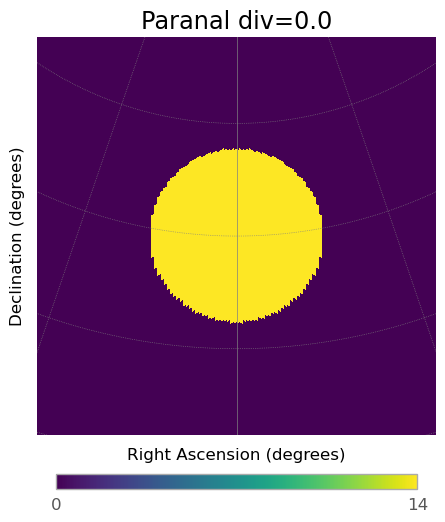

14it [00:01,  7.30it/s]
14it [00:01,  7.10it/s]


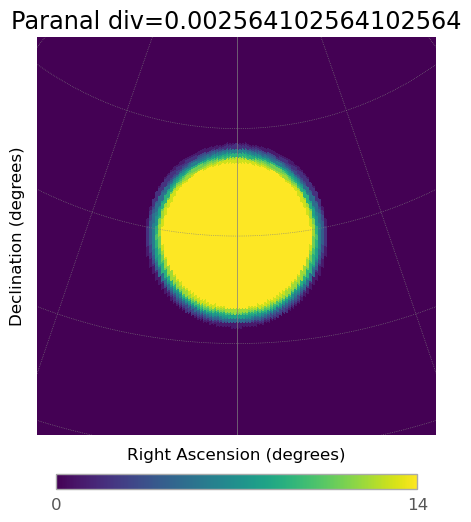

14it [00:01,  7.35it/s]
14it [00:01,  7.15it/s]


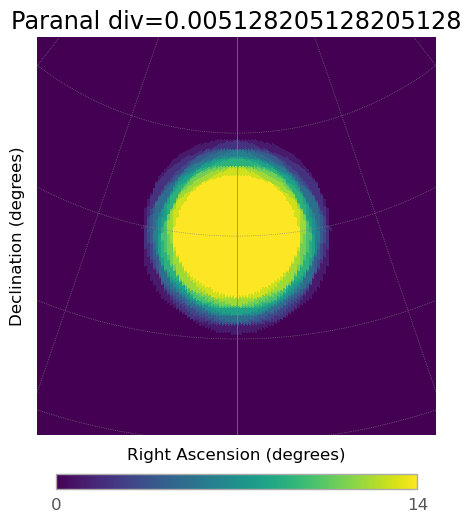

14it [00:02,  6.10it/s]
14it [00:01,  7.24it/s]


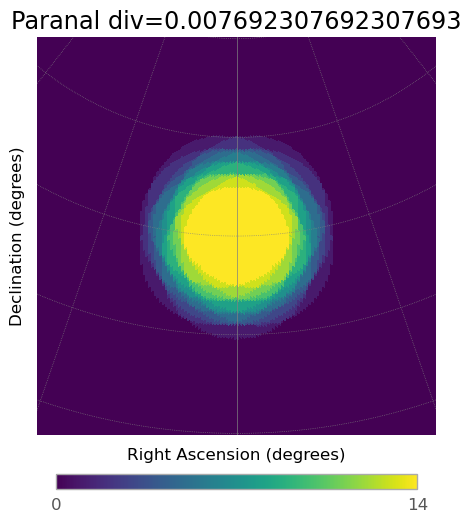

14it [00:02,  6.67it/s]
14it [00:02,  6.89it/s]


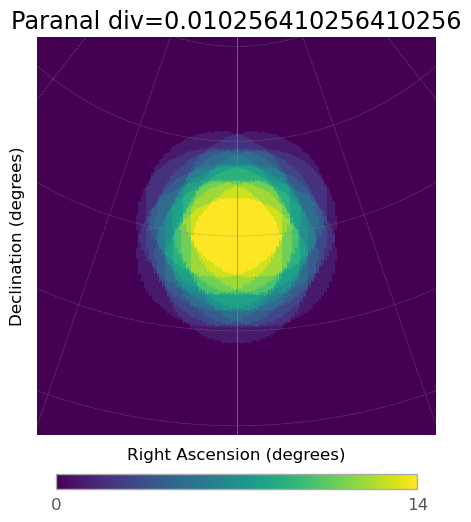

14it [00:01,  7.23it/s]
14it [00:01,  7.19it/s]


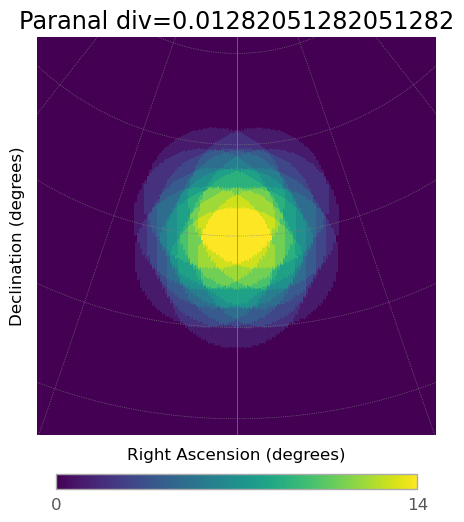

14it [00:01,  7.40it/s]
14it [00:01,  7.09it/s]


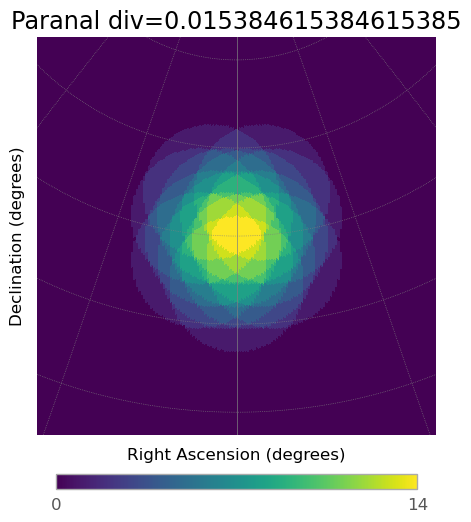

14it [00:01,  7.46it/s]
14it [00:01,  7.23it/s]


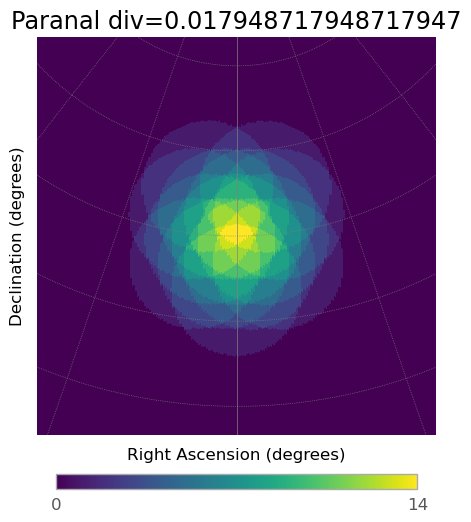

14it [00:02,  6.84it/s]
14it [00:01,  7.17it/s]


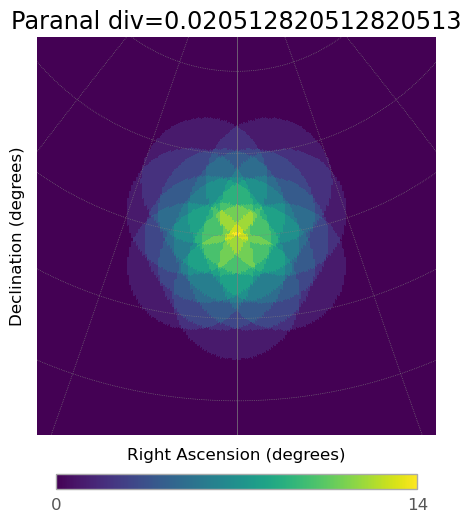

14it [00:01,  7.41it/s]
14it [00:01,  7.05it/s]


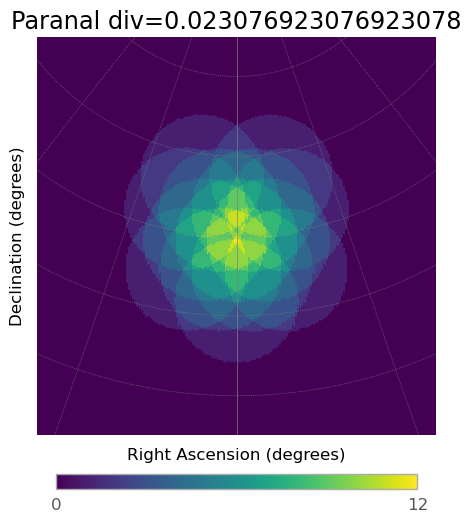

14it [00:02,  6.98it/s]
14it [00:01,  7.18it/s]


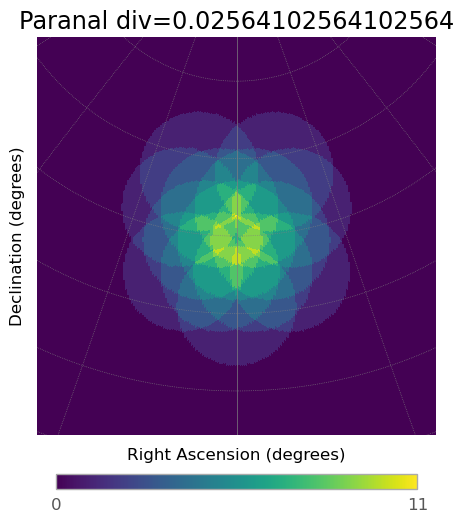

14it [00:01,  7.40it/s]
14it [00:01,  7.22it/s]


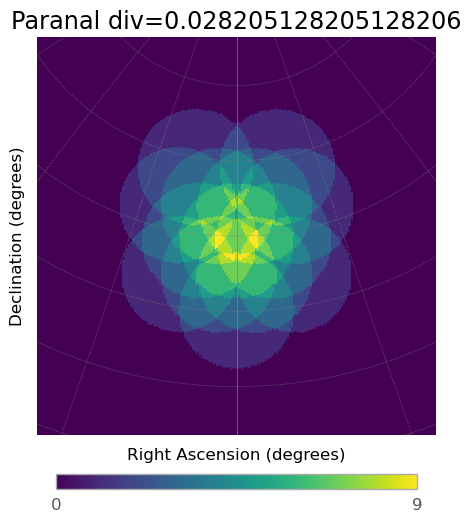

14it [00:01,  7.29it/s]
14it [00:01,  7.11it/s]


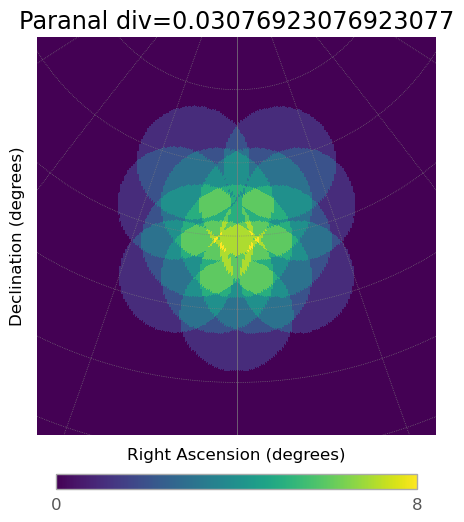

14it [00:01,  7.26it/s]
14it [00:01,  7.07it/s]


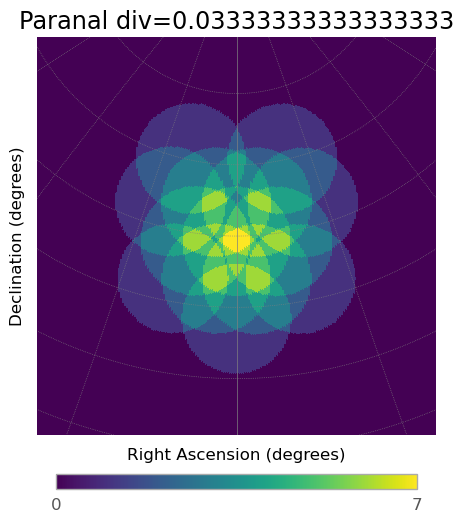

14it [00:01,  7.34it/s]
14it [00:02,  6.90it/s]


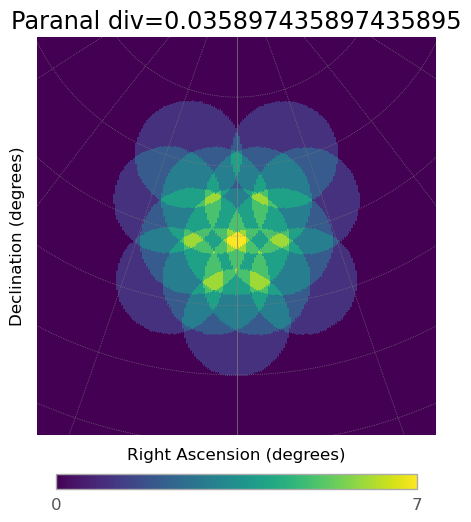

In [174]:
for divergence in stop_div:
    full_array.divergent_pointing(div=divergence, az=0, alt=70)
    full_array.multiplicity_plot()


4it [00:00,  7.30it/s]
4it [00:00,  6.81it/s]


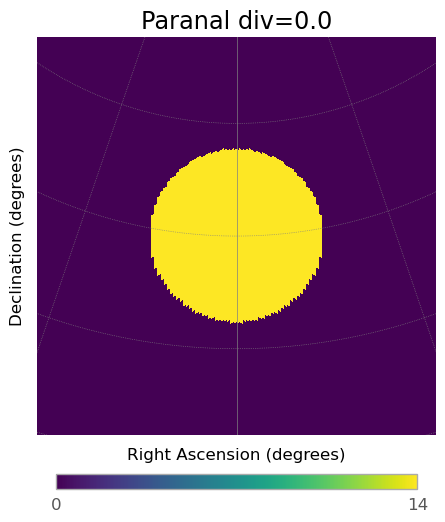

4it [00:00,  7.24it/s]
4it [00:00,  6.79it/s]


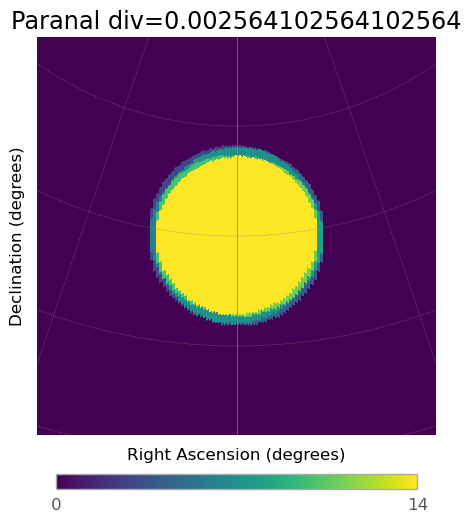

4it [00:00,  7.28it/s]
4it [00:00,  6.40it/s]


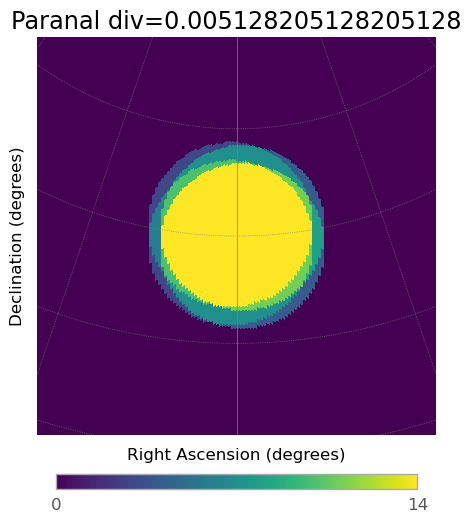

4it [00:00,  7.16it/s]
4it [00:00,  7.01it/s]


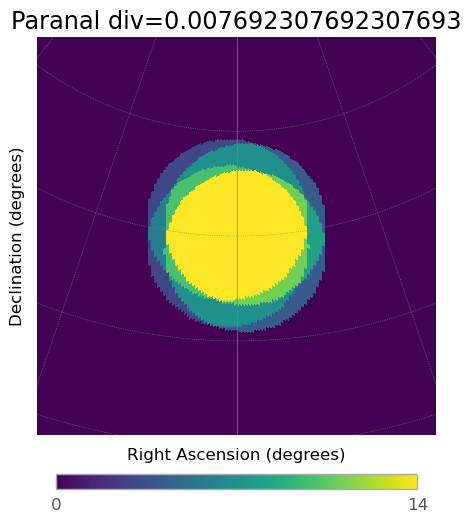

4it [00:00,  7.43it/s]
4it [00:00,  6.76it/s]


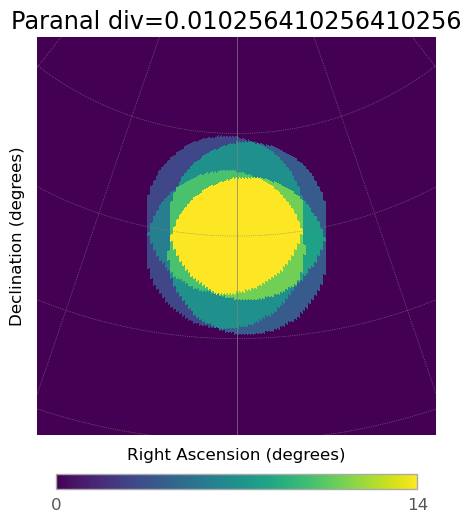

4it [00:00,  7.36it/s]
4it [00:00,  6.63it/s]


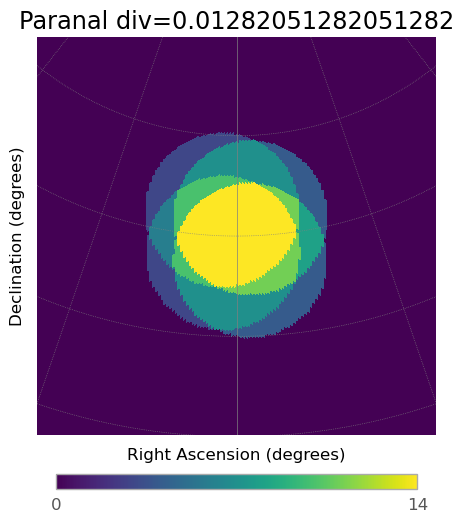

4it [00:00,  7.22it/s]
4it [00:00,  6.96it/s]


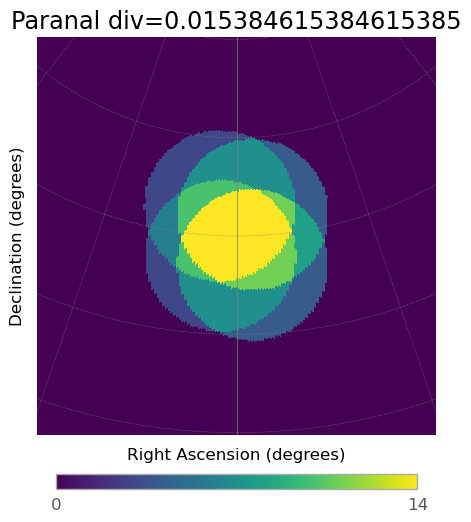

4it [00:00,  7.21it/s]
4it [00:00,  5.86it/s]


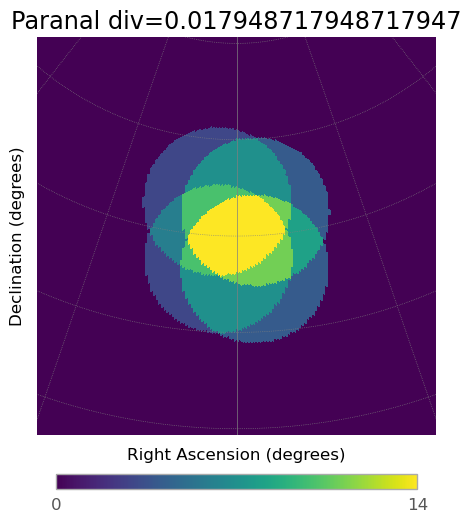

4it [00:00,  7.30it/s]
4it [00:00,  6.84it/s]


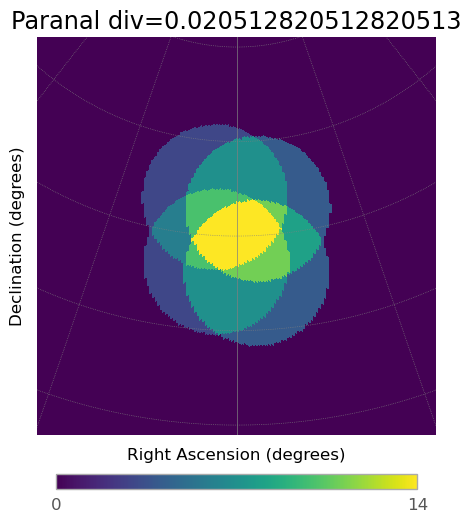

4it [00:00,  7.22it/s]
4it [00:00,  6.82it/s]


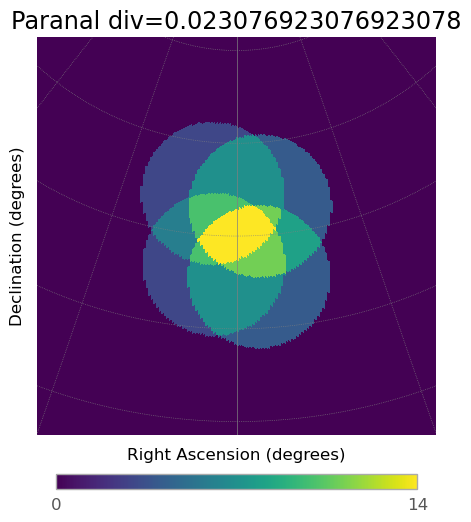

4it [00:00,  7.29it/s]
4it [00:00,  6.68it/s]


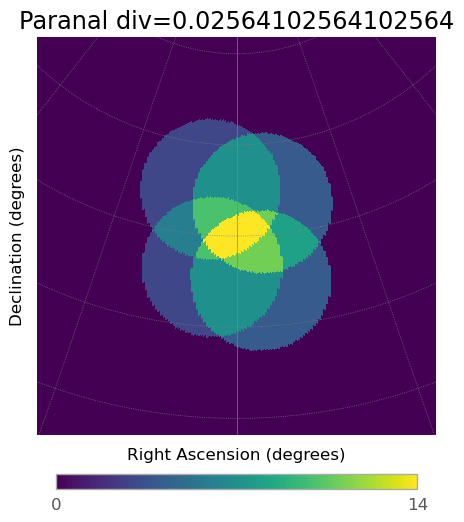

4it [00:00,  7.38it/s]
4it [00:00,  6.79it/s]


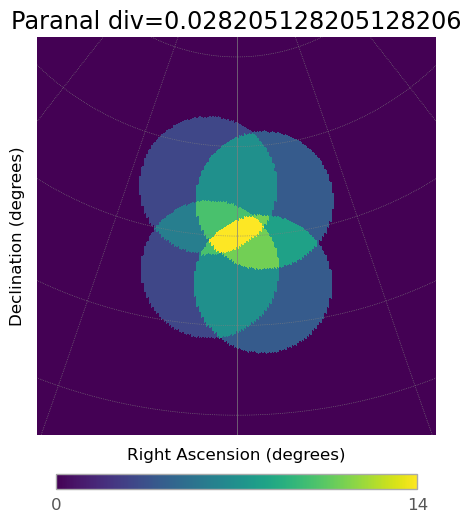

4it [00:00,  7.19it/s]
4it [00:00,  6.91it/s]


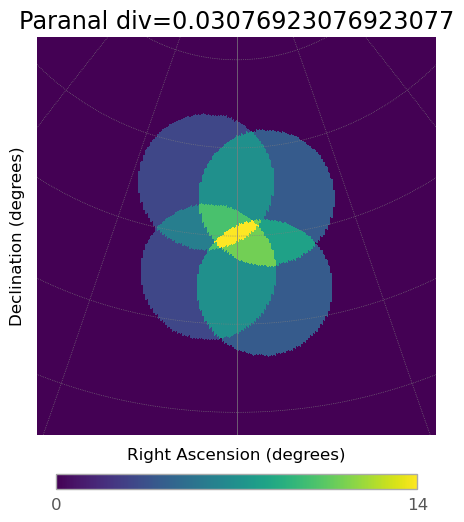

4it [00:00,  7.45it/s]
4it [00:00,  6.57it/s]


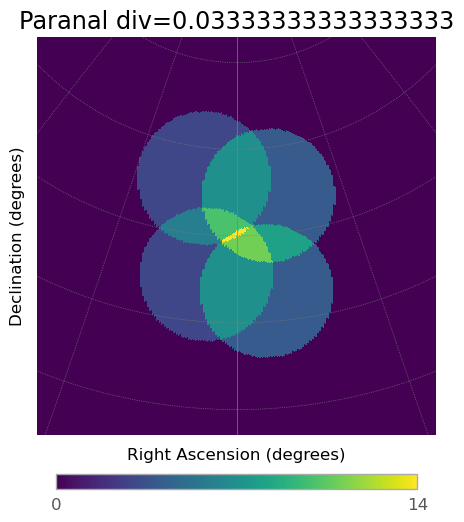

4it [00:00,  7.24it/s]
4it [00:00,  6.53it/s]


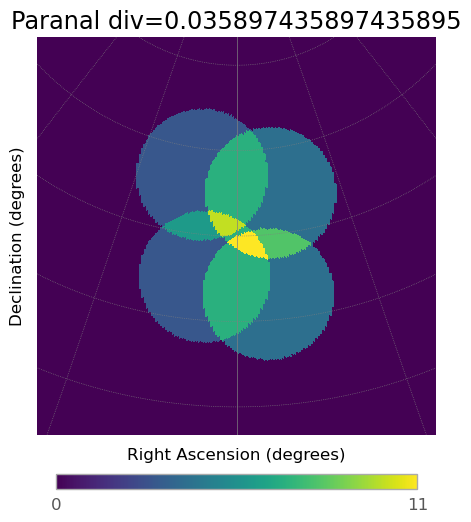

In [175]:
for divergence in stop_div:
    array.divergent_pointing(div=divergence, az=0, alt=70)
    array.multiplicity_plot(number_of_telescopes_subarray_1)

In [176]:
##Puting a different stop to the full the configuration 1 and configuration 2 
stop_sub_1_2_full=0.033 #From what we saw in the previous slides 
stop_div_sub_1_2_full=[]
for div in stop_div:
    print(div)
    if np.round(div,3) <= stop_sub_1_2_full: 
        stop_div_sub_1_2_full.append(div)
array_slice_stop_sub_1_2_full = np.size(stop_div_sub_1_2_full) #This is to slice the array

0.0
0.002564102564102564
0.005128205128205128
0.007692307692307693
0.010256410256410256
0.01282051282051282
0.015384615384615385
0.017948717948717947
0.020512820512820513
0.023076923076923078
0.02564102564102564
0.028205128205128206
0.03076923076923077
0.03333333333333333
0.035897435897435895


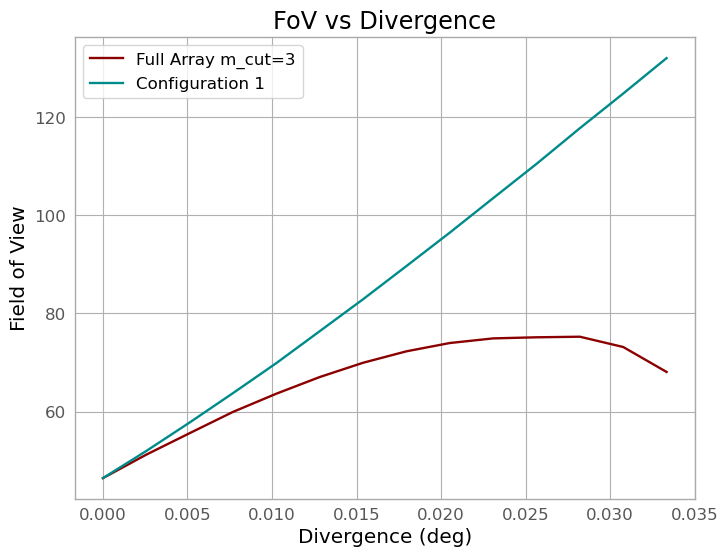

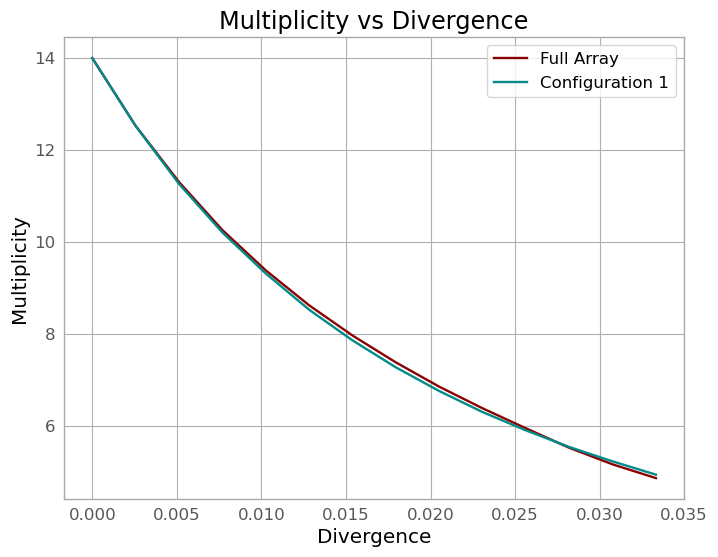

In [177]:
plt.plot(stop_div_sub_1_2_full, FoV_full_array[:array_slice_stop_sub_1_2_full], label='Full Array m_cut=3', color='darkred')
plt.plot(stop_div_sub_1_2_full, FoV_array[:array_slice_stop_sub_1_2_full], label='Configuration 1', color='darkcyan')
#plt.plot(stop_div_sub_1_2_full, FoV_array_2[:array_slice_stop_sub_1_2_full], label='Configuration 2', color='darkgreen')
#plt.plot(stop_div, FoV_array_3[:array_slice_stop], label='Configuration 3',color='limegreen')

# Add labels and title
plt.xlabel("Divergence (deg)")  
plt.ylabel("Field of View")  
plt.title("FoV vs Divergence")  

# Add legend
plt.legend()

# Display the plot
plt.show()
plt.plot(stop_div_sub_1_2_full, multiplicity_full_array[:array_slice_stop_sub_1_2_full], label='Full Array', color='darkred')
plt.plot(stop_div_sub_1_2_full,  multiplicity_array[:array_slice_stop_sub_1_2_full], label='Configuration 1', color='darkcyan')


plt.xlabel("Divergence")  
plt.ylabel("Multiplicity")  # Y-axis label
plt.title("Multiplicity vs Divergence")  # Title of the plot
plt.legend()
plt.show()

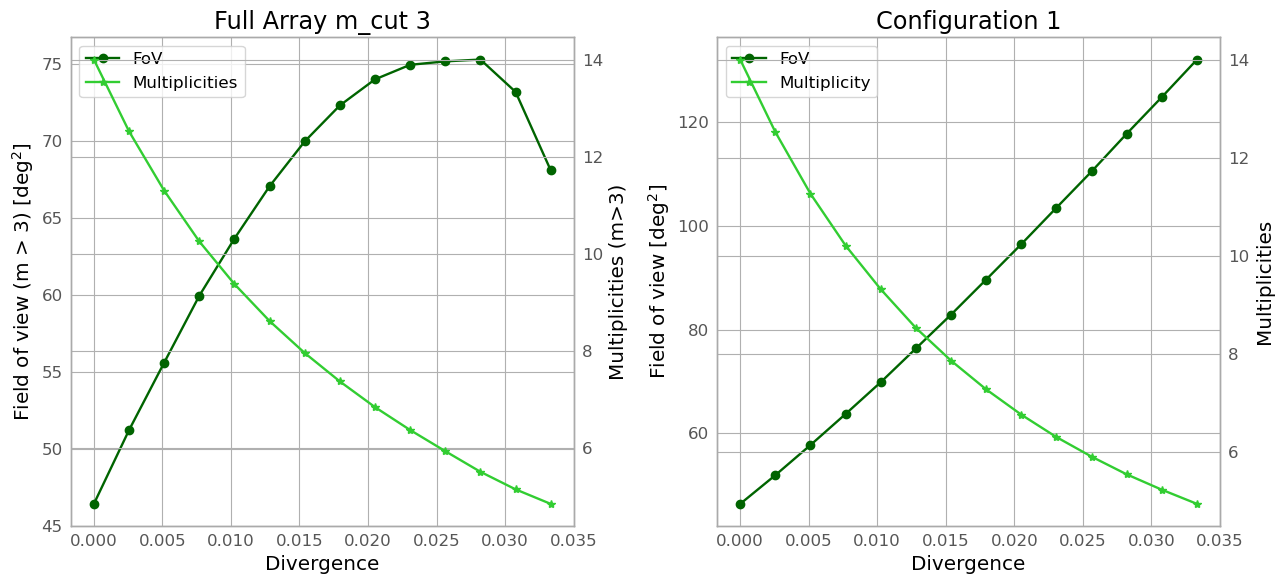

In [178]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6)) 
# Plot Full Array
# Full Array with m_cut = 3
l1=axes[0].plot(stop_div_sub_1_2_full, FoV_full_array[:array_slice_stop_sub_1_2_full], label='FoV', marker='o', color='darkgreen')
ax2 = axes[0].twinx()
l2=ax2.plot(stop_div_sub_1_2_full, multiplicity_full_array[:array_slice_stop_sub_1_2_full], label='Multiplicities',marker='*', color='limegreen')
axes[0].set_title('Full Array m_cut 3')
axes[0].set_xlabel('Divergence')
axes[0].set_ylabel('Field of view (m > 3) [deg$^2$]')
ax2.set_ylabel('Multiplicities (m>3)')
axeslegend = l1+l2
axes[0].legend(axeslegend, [l.get_label() for l in axeslegend])



#Plot the ones for subarray 1
l1=axes[1].plot(stop_div_sub_1_2_full, FoV_array[:array_slice_stop_sub_1_2_full], label='FoV',marker='o', color='darkgreen')
ax5=axes[1].twinx()
l2=ax5.plot(stop_div_sub_1_2_full, multiplicity_array[:array_slice_stop_sub_1_2_full], label='Multiplicity', marker='*', color='limegreen')
axes[1].set_title('Configuration 1')
axes[1].set_xlabel('Divergence')
axes[1].set_ylabel('Field of view [deg$^2$]')
ax5.set_ylabel('Multiplicities')
axeslegend = l1+l2
axes[1].legend(axeslegend, [l.get_label() for l in axeslegend])
#Plot the ones for subarray 2

# Adjust layout
plt.tight_layout()
# Subarray 4
#l1=axes[2,1].plot(stop_div, FoV_array_4[:array_slice_stop], label='FoV',marker='o', color='darkgreen')
#ax3 = axes[2,1].twinx()
#l2=ax3.plot(stop_div,multiplicity_array_4[:array_slice_stop], label='Multiplicities', marker='*', color='limegreen')
#plt.title('Subarray 4')
#plt.xlabel('Divergence')
#plt.ylabel('Field of view  [deg$^2$]')
#plt.ylabel('Multiplicities')
#axeslegend = l1+l2
#axes[2,1].legend(axeslegend, [l.get_label() for l in axeslegend])
# Adjust layout



plt.show()

## COMPARISSON BETWEEN THE ARRAY AND THE HFOV 

In [179]:
chosen_divergences=[0.0022,0.0043, 0.008, 0.01135, 0.01453]
FoV_array_div_chosen=[]
av_multiplicity_array_div_chosen=[]

for divergence in chosen_divergences:
    array.divergent_pointing(divergence, az=0,alt=70)    
    FoV=array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0]
    print(f"The FoV of {divergence} is {FoV}")
    multiplicity=array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1]
    print(f"The multiplicity of {divergence} is {multiplicity}")
    FoV_array_div_chosen.append(FoV)
    av_multiplicity_array_div_chosen.append(multiplicity)
    

4it [00:00,  7.07it/s]


The FoV of 0.0022 is 51.32805198994542


4it [00:00,  7.26it/s]


The multiplicity of 0.0022 is 12.70056208482371


4it [00:00,  7.26it/s]


The FoV of 0.0043 is 56.06219270746465


4it [00:00,  7.23it/s]


The multiplicity of 0.0043 is 11.630175438596492


4it [00:00,  7.24it/s]


The FoV of 0.008 is 64.5469269020213


4it [00:00,  7.03it/s]


The multiplicity of 0.008 is 10.083299471759448


4it [00:00,  7.29it/s]


The FoV of 0.01135 is 72.86117957489442


4it [00:00,  7.18it/s]


The multiplicity of 0.01135 is 8.943664506839452


4it [00:00,  7.14it/s]


The FoV of 0.01453 is 80.87381109401977


4it [00:00,  6.95it/s]

The multiplicity of 0.01453 is 8.061942597697422


In [180]:
FoV_full_array=[]
multiplicity_full_array=[]
for divergence in chosen_divergences:
    full_array.divergent_pointing(divergence, az=0,alt=70)
    if full_array.hFoV(m_cut=3)[0] != 0: #To get the no saturation, because what happens is that when it looses focus due to the separation, we will just get 0 FoV
        FoV=full_array.hFoV(m_cut=3)[0]
        print(f"The FoV of {divergence} is {FoV}")
        multiplicity=full_array.hFoV(m_cut=3)[1]
        FoV_full_array.append(FoV)
        multiplicity_full_array.append(multiplicity)
        print(f"The multiplicity of {divergence} is {multiplicity}")
        div_no_saturation_full_array.append(divergence)

14it [00:01,  7.34it/s]
14it [00:01,  7.28it/s]


The FoV of 0.0022 is 50.52810023435352


14it [00:01,  7.21it/s]


The multiplicity of 0.0022 is 12.718920321827147


14it [00:01,  7.24it/s]
14it [00:01,  7.34it/s]


The FoV of 0.0043 is 54.1606680425331


14it [00:01,  7.28it/s]


The multiplicity of 0.0043 is 11.680387409200968


14it [00:01,  7.21it/s]
14it [00:01,  7.21it/s]


The FoV of 0.008 is 60.44225641841043


14it [00:01,  7.40it/s]


The multiplicity of 0.008 is 10.135821219353438


14it [00:01,  7.33it/s]
14it [00:01,  7.26it/s]


The FoV of 0.01135 is 65.28130884158107


14it [00:01,  7.16it/s]


The multiplicity of 0.01135 is 9.033346725592608


14it [00:01,  7.24it/s]
14it [00:02,  6.78it/s]


The FoV of 0.01453 is 69.20238384030199


14it [00:01,  7.38it/s]

The multiplicity of 0.01453 is 8.163160886867539


In [181]:
FoV_full_array_no_multiplicity_cut=[]
multiplicity_full_array_no_multiplicity_cut=[]
for divergence in chosen_divergences:
    full_array.divergent_pointing(divergence, az=0,alt=70)
    if full_array.hFoV()[0] != 0: #To get the no saturation, because what happens is that when it looses focus due to the separation, we will just get 0 FoV
        FoV=full_array.hFoV()[0]
        print(f"The FoV of {divergence} is {FoV}")
        multiplicity=full_array.hFoV()[1]
        FoV_full_array_no_multiplicity_cut.append(FoV)
        multiplicity_full_array_no_multiplicity_cut.append(multiplicity)
        print(f"The multiplicity of {divergence} is {multiplicity}")
       

14it [00:01,  7.39it/s]
14it [00:01,  7.28it/s]


The FoV of 0.0022 is 55.76057155371689


14it [00:01,  7.26it/s]


The multiplicity of 0.0022 is 11.690498588899342


14it [00:01,  7.31it/s]
14it [00:01,  7.34it/s]


The FoV of 0.0043 is 65.32065073120035


14it [00:01,  7.27it/s]


The multiplicity of 0.0043 is 9.98173057618952


14it [00:01,  7.29it/s]
14it [00:01,  7.34it/s]


The FoV of 0.008 is 83.07695691269909


14it [00:01,  7.24it/s]


The multiplicity of 0.008 is 7.84498816101026


14it [00:01,  7.44it/s]
14it [00:01,  7.26it/s]


The FoV of 0.01135 is 101.34470765924839


14it [00:01,  7.12it/s]


The multiplicity of 0.01135 is 6.428312629399586


14it [00:01,  7.13it/s]
14it [00:01,  7.40it/s]


The FoV of 0.01453 is 119.91407955954546


14it [00:01,  7.39it/s]

The multiplicity of 0.01453 is 5.4332895888014


4it [00:00,  7.15it/s]
4it [00:00,  6.79it/s]


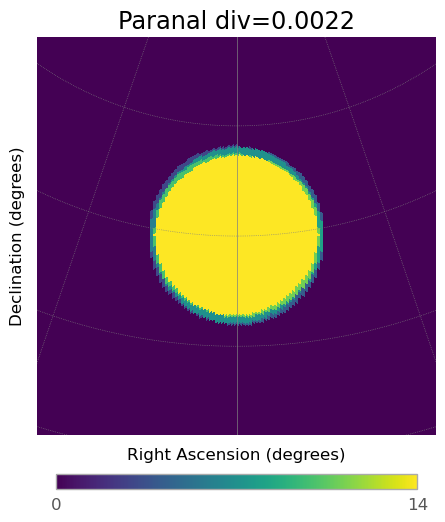

4it [00:00,  7.32it/s]
4it [00:00,  7.08it/s]


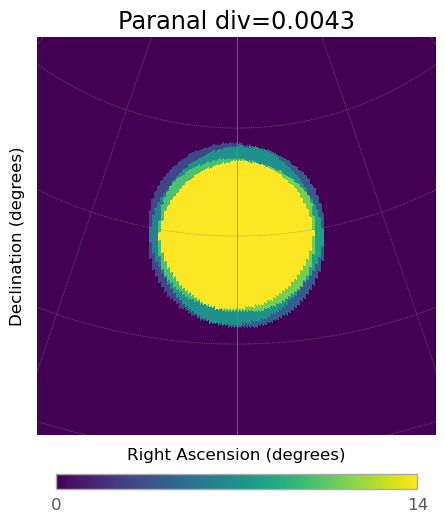

4it [00:00,  7.32it/s]
4it [00:00,  6.69it/s]


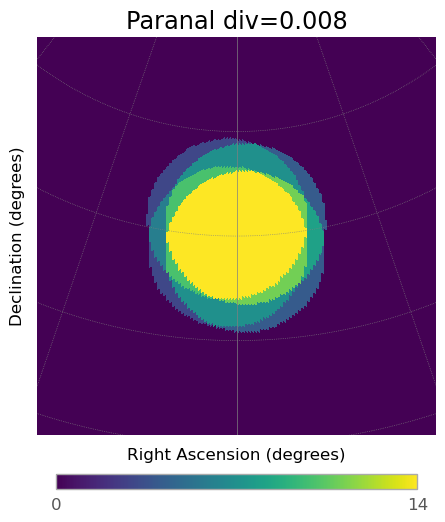

4it [00:00,  7.15it/s]
4it [00:00,  6.83it/s]


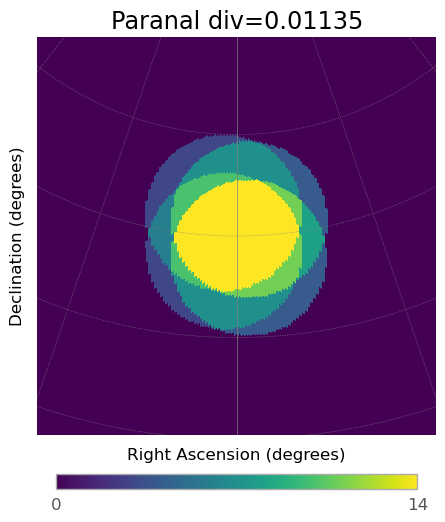

4it [00:00,  7.08it/s]
4it [00:00,  6.00it/s]


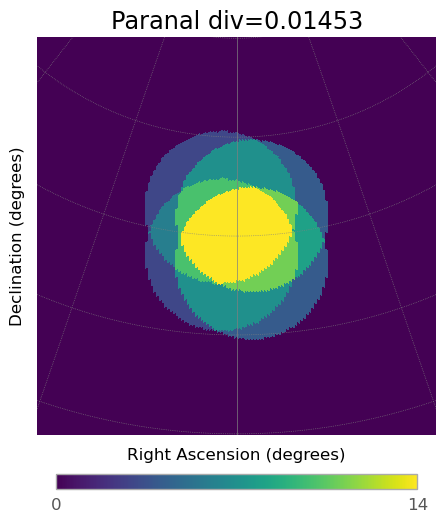

In [182]:
for divergence in chosen_divergences:
    array.divergent_pointing(div=divergence, az=0, alt=70)
    array.multiplicity_plot(number_of_telescopes_subarray_1)

14it [00:01,  7.33it/s]
14it [00:01,  7.07it/s]


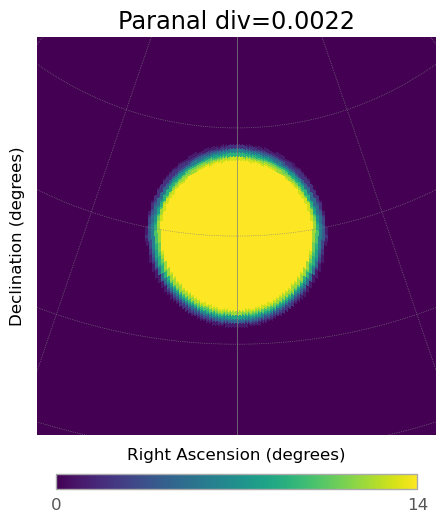

14it [00:01,  7.25it/s]
14it [00:01,  7.10it/s]


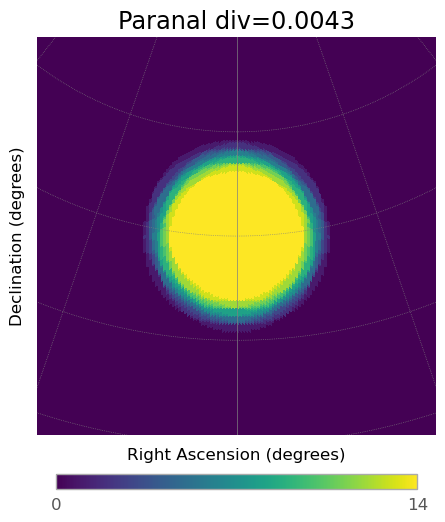

14it [00:01,  7.36it/s]
14it [00:01,  7.22it/s]


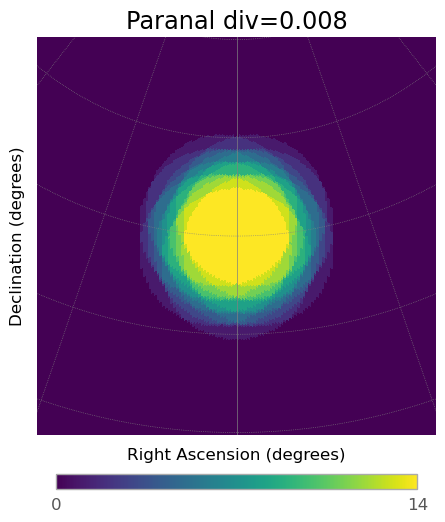

14it [00:01,  7.37it/s]
14it [00:01,  7.18it/s]


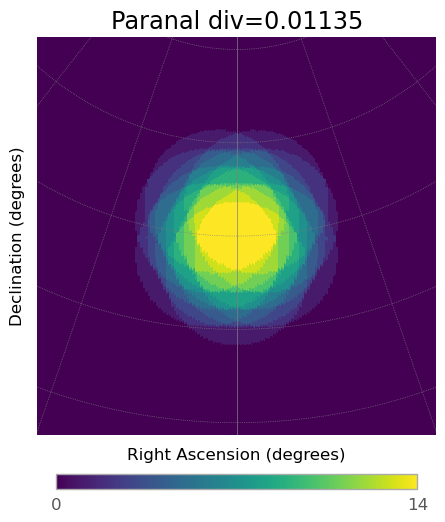

14it [00:01,  7.01it/s]
14it [00:01,  7.22it/s]


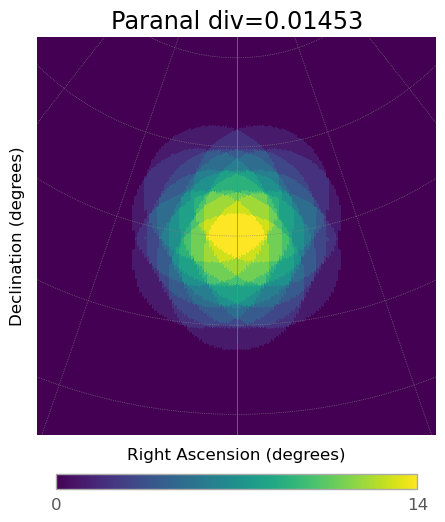

In [183]:
for divergence in chosen_divergences:
    full_array.divergent_pointing(div=divergence, az=0, alt=70)
    full_array.multiplicity_plot()


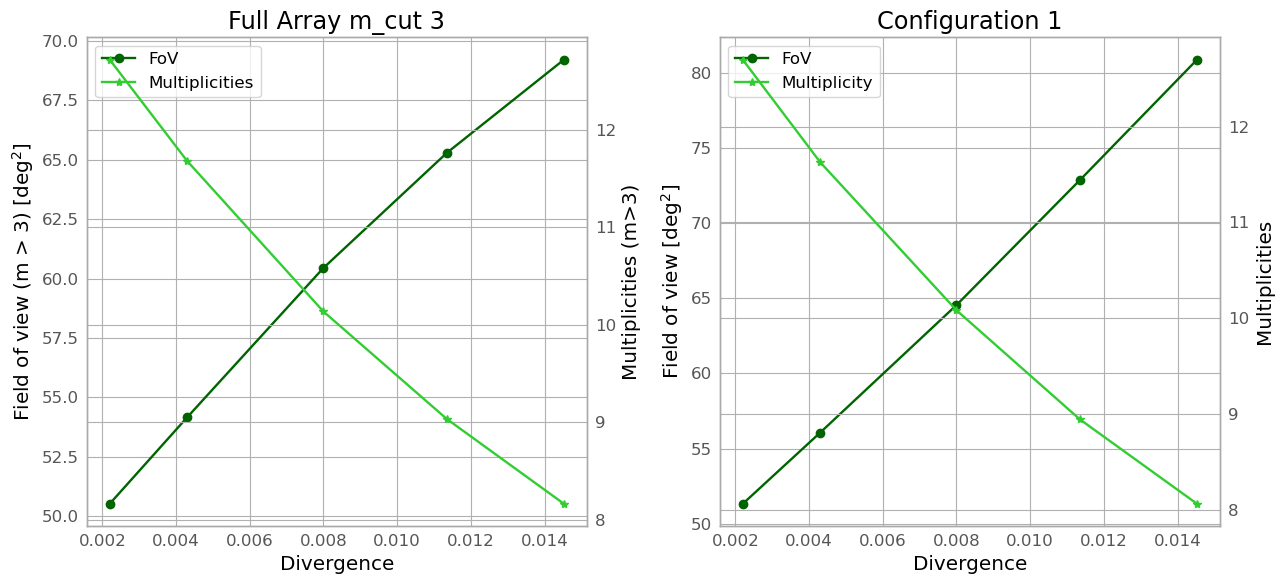

In [184]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6)) 
# Plot Full Array
# Full Array with m_cut = 3
l1=axes[0].plot(chosen_divergences, FoV_full_array, label='FoV', marker='o', color='darkgreen')
ax2 = axes[0].twinx()
l2=ax2.plot(chosen_divergences, multiplicity_full_array, label='Multiplicities',marker='*', color='limegreen')
axes[0].set_title('Full Array m_cut 3')
axes[0].set_xlabel('Divergence')
axes[0].set_ylabel('Field of view (m > 3) [deg$^2$]')
ax2.set_ylabel('Multiplicities (m>3)')
axeslegend = l1+l2
axes[0].legend(axeslegend, [l.get_label() for l in axeslegend])



#Plot the ones for subarray 1
l1=axes[1].plot(chosen_divergences, FoV_array_div_chosen, label='FoV',marker='o', color='darkgreen')
ax5=axes[1].twinx()
l2=ax5.plot(chosen_divergences, av_multiplicity_array_div_chosen, label='Multiplicity', marker='*', color='limegreen')
axes[1].set_title('Configuration 1')
axes[1].set_xlabel('Divergence')
axes[1].set_ylabel('Field of view [deg$^2$]')
ax5.set_ylabel('Multiplicities')
axeslegend = l1+l2
axes[1].legend(axeslegend, [l.get_label() for l in axeslegend])
#Plot the ones for subarray 2

# Adjust layout
plt.tight_layout()
# Subarray 4
# Adjust layout
plt.show()

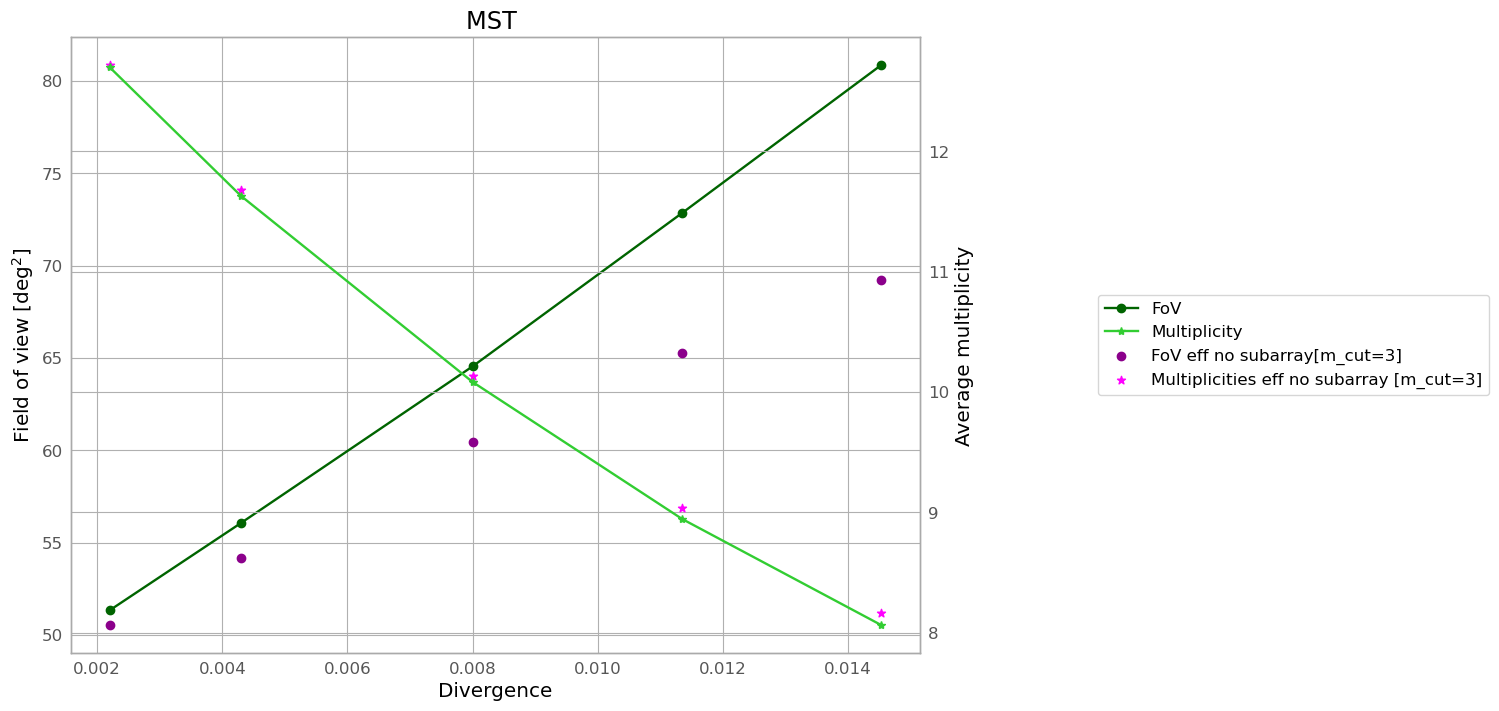

In [185]:
f, ax = plt.subplots(1, 1, figsize=(10,7))
p1 = ax.plot(chosen_divergences, FoV_array_div_chosen, label='FoV',marker='o', color='darkgreen')
p3=plt.scatter(chosen_divergences, FoV_full_array, label='FoV eff no subarray[m_cut=3]', marker='o', color='darkmagenta')
#p5=plt.scatter(chosen_divergences, FoV_full_array_no_multiplicity_cut, label='FoV no  subarray nor m_cut', marker='o', color='navy')
ax.set_xlabel('Divergence')
ax.set_ylabel('Field of view [deg$^2$]')


ax2 = ax.twinx()
p2 = ax2.plot(chosen_divergences, av_multiplicity_array_div_chosen, label='Multiplicity', marker='*', color='limegreen')
ax2.set_ylabel("Average multiplicity")
plt.tight_layout()
plt.title("MST ")

p4=plt.scatter(chosen_divergences, multiplicity_full_array, label='Multiplicities eff no subarray [m_cut=3]',marker='*', color='magenta')
#p6=plt.scatter(chosen_divergences, multiplicity_full_array_no_multiplicity_cut, label='Multiplicity no  subarray nor m_cut', marker='*', color='royalblue')
ps = p1+p2+[p3]+[p4]
ax.legend(ps, [p.get_label() for p in ps], loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

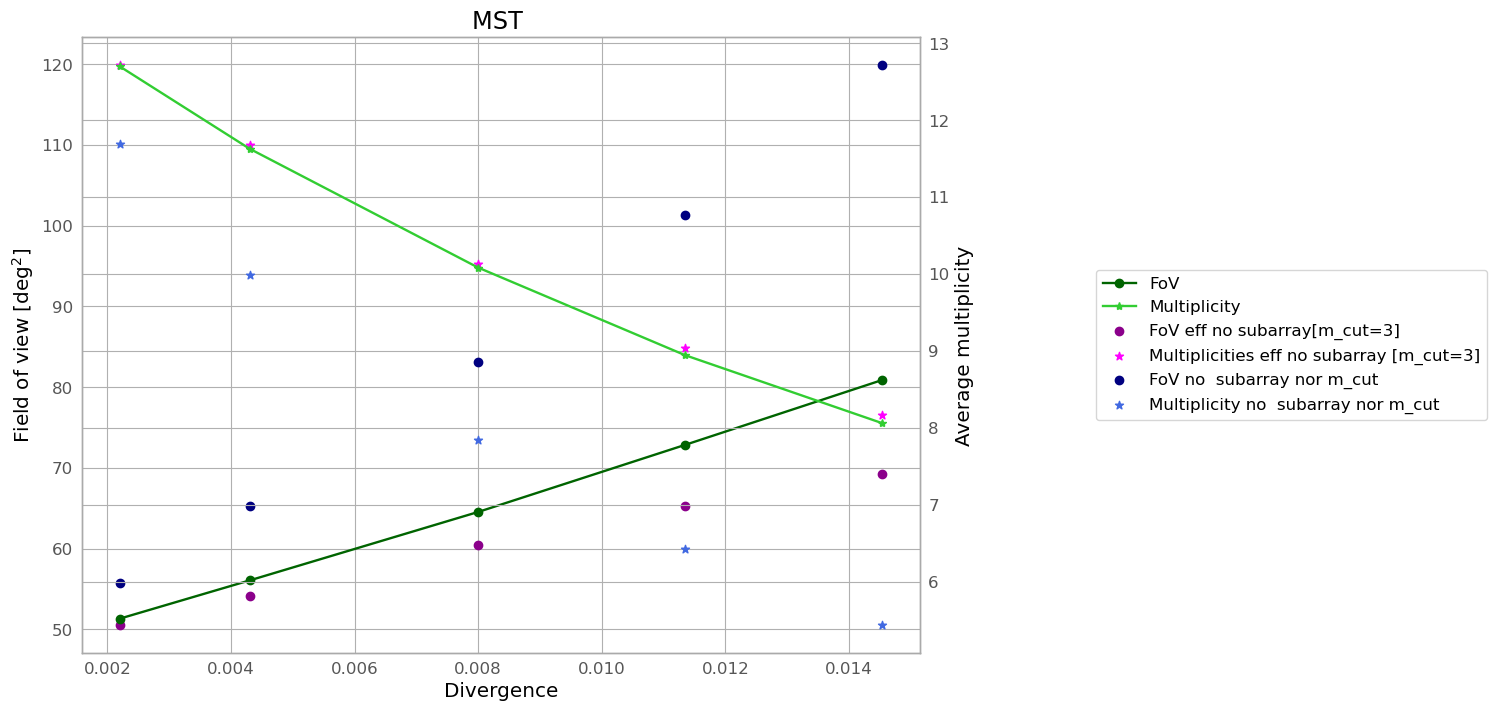

In [186]:
f, ax = plt.subplots(1, 1, figsize=(10,7))
p1 = ax.plot(chosen_divergences, FoV_array_div_chosen, label='FoV',marker='o', color='darkgreen')
p3=plt.scatter(chosen_divergences, FoV_full_array, label='FoV eff no subarray[m_cut=3]', marker='o', color='darkmagenta')
p5=plt.scatter(chosen_divergences, FoV_full_array_no_multiplicity_cut, label='FoV no  subarray nor m_cut', marker='o', color='navy')
ax.set_xlabel('Divergence')
ax.set_ylabel('Field of view [deg$^2$]')


ax2 = ax.twinx()
p2 = ax2.plot(chosen_divergences, av_multiplicity_array_div_chosen, label='Multiplicity', marker='*', color='limegreen')
ax2.set_ylabel("Average multiplicity")
plt.tight_layout()
plt.title("MST ")

p4=plt.scatter(chosen_divergences, multiplicity_full_array, label='Multiplicities eff no subarray [m_cut=3]',marker='*', color='magenta')
p6=plt.scatter(chosen_divergences, multiplicity_full_array_no_multiplicity_cut, label='Multiplicity no  subarray nor m_cut', marker='*', color='royalblue')
ps = p1+p2+[p3]+[p4] +[p5]+[p6]
ax.legend(ps, [p.get_label() for p in ps], loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

## INCREASING

In [187]:
chosen_divergences=[0.0022,0.0043, 0.008, 0.01135, 0.01453, 0.01753, 0.02053, 0.02353, 0.02653, 0.02953]
FoV_array_div_chosen=[]
av_multiplicity_array_div_chosen=[]

for divergence in chosen_divergences:
    array.divergent_pointing(divergence, az=0,alt=70)    
    FoV=array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0]
    print(f"The FoV of {divergence} is {FoV}")
    multiplicity=array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1]
    print(f"The multiplicity of {divergence} is {multiplicity}")
    FoV_array_div_chosen.append(FoV)
    av_multiplicity_array_div_chosen.append(multiplicity)
    

4it [00:00,  7.46it/s]


The FoV of 0.0022 is 51.32805198994542


4it [00:00,  7.54it/s]


The multiplicity of 0.0022 is 12.70056208482371


4it [00:00,  7.26it/s]


The FoV of 0.0043 is 56.06219270746465


4it [00:00,  7.32it/s]


The multiplicity of 0.0043 is 11.630175438596492


4it [00:00,  7.32it/s]


The FoV of 0.008 is 64.5469269020213


4it [00:00,  7.31it/s]


The multiplicity of 0.008 is 10.083299471759448


4it [00:00,  7.47it/s]


The FoV of 0.01135 is 72.86117957489442


4it [00:00,  7.12it/s]


The multiplicity of 0.01135 is 8.943664506839452


4it [00:00,  7.22it/s]


The FoV of 0.01453 is 80.87381109401977


4it [00:00,  7.37it/s]


The multiplicity of 0.01453 is 8.061942597697422


4it [00:00,  7.28it/s]


The FoV of 0.01753 is 88.5979354226038


4it [00:00,  7.50it/s]


The multiplicity of 0.01753 is 7.35287152161042


4it [00:00,  7.50it/s]


The FoV of 0.02053 is 96.54499712569702


4it [00:00,  7.32it/s]


The multiplicity of 0.02053 is 6.748709589785385


4it [00:00,  7.42it/s]


The FoV of 0.02353 is 104.79367998253802


4it [00:00,  7.37it/s]


The multiplicity of 0.02353 is 6.222250031285196


4it [00:00,  7.13it/s]


The FoV of 0.02653 is 112.95056509693406


4it [00:00,  7.30it/s]


The multiplicity of 0.02653 is 5.765586903517938


4it [00:00,  7.28it/s]


The FoV of 0.02953 is 121.38284343866499


4it [00:00,  6.89it/s]

The multiplicity of 0.02953 is 5.363872082973207


In [188]:
FoV_full_array=[]
multiplicity_full_array=[]
for divergence in chosen_divergences:
    full_array.divergent_pointing(divergence, az=0,alt=70)
    if full_array.hFoV(m_cut=3)[0] != 0: #To get the no saturation, because what happens is that when it looses focus due to the separation, we will just get 0 FoV
        FoV=full_array.hFoV(m_cut=3)[0]
        print(f"The FoV of {divergence} is {FoV}")
        multiplicity=full_array.hFoV(m_cut=3)[1]
        FoV_full_array.append(FoV)
        multiplicity_full_array.append(multiplicity)
        print(f"The multiplicity of {divergence} is {multiplicity}")
        div_no_saturation_full_array.append(divergence)

14it [00:01,  7.24it/s]
14it [00:01,  7.27it/s]


The FoV of 0.0022 is 50.52810023435352


14it [00:01,  7.25it/s]


The multiplicity of 0.0022 is 12.718920321827147


14it [00:01,  7.25it/s]
14it [00:01,  7.31it/s]


The FoV of 0.0043 is 54.1606680425331


14it [00:01,  7.39it/s]


The multiplicity of 0.0043 is 11.680387409200968


14it [00:01,  7.02it/s]
14it [00:01,  7.23it/s]


The FoV of 0.008 is 60.44225641841043


14it [00:01,  7.33it/s]


The multiplicity of 0.008 is 10.135821219353438


14it [00:01,  7.15it/s]
14it [00:01,  7.32it/s]


The FoV of 0.01135 is 65.28130884158107


14it [00:01,  7.40it/s]


The multiplicity of 0.01135 is 9.033346725592608


14it [00:01,  7.31it/s]
14it [00:01,  7.47it/s]


The FoV of 0.01453 is 69.20238384030199


14it [00:01,  7.31it/s]


The multiplicity of 0.01453 is 8.163160886867539


14it [00:01,  7.00it/s]
14it [00:01,  7.36it/s]


The FoV of 0.01753 is 72.08745574571537


14it [00:01,  7.32it/s]


The multiplicity of 0.01753 is 7.458068037111151


14it [00:01,  7.35it/s]
14it [00:01,  7.30it/s]


The FoV of 0.02053 is 73.9758664474405


14it [00:01,  7.30it/s]


The multiplicity of 0.02053 is 6.845062932104237


14it [00:01,  7.41it/s]
14it [00:01,  7.41it/s]


The FoV of 0.02353 is 75.0512114303673


14it [00:01,  7.37it/s]


The multiplicity of 0.02353 is 6.297396470382666


14it [00:01,  7.25it/s]
14it [00:01,  7.14it/s]


The FoV of 0.02653 is 75.45774428976647


14it [00:01,  7.26it/s]


The multiplicity of 0.02653 is 5.78484532499131


14it [00:01,  7.35it/s]
14it [00:01,  7.32it/s]


The FoV of 0.02953 is 74.74959027661954


14it [00:01,  7.32it/s]

The multiplicity of 0.02953 is 5.314736842105263


In [194]:
FoV_full_array_no_multiplicity_cut=[]
multiplicity_full_array_no_multiplicity_cut=[]
for divergence in chosen_divergences:
    full_array.divergent_pointing(divergence, az=0,alt=70)
    if full_array.hFoV()[0] != 0: #To get the no saturation, because what happens is that when it looses focus due to the separation, we will just get 0 FoV
        FoV=full_array.hFoV()[0]
        print(f"The FoV of {divergence} is {FoV}")
        multiplicity=full_array.hFoV()[1]
        FoV_full_array_no_multiplicity_cut.append(FoV)
        multiplicity_full_array_no_multiplicity_cut.append(multiplicity)
        print(f"The multiplicity of {divergence} is {multiplicity}")
       

14it [00:01,  7.35it/s]
14it [00:01,  7.38it/s]


The FoV of 0.0022 is 55.76057155371689


14it [00:01,  7.14it/s]


The multiplicity of 0.0022 is 11.690498588899342


14it [00:01,  7.14it/s]
14it [00:01,  7.25it/s]


The FoV of 0.0043 is 65.32065073120035


14it [00:01,  7.26it/s]


The multiplicity of 0.0043 is 9.98173057618952


14it [00:02,  6.85it/s]
14it [00:01,  7.31it/s]


The FoV of 0.008 is 83.07695691269909


14it [00:01,  7.36it/s]


The multiplicity of 0.008 is 7.84498816101026


14it [00:01,  7.21it/s]
14it [00:01,  7.20it/s]


The FoV of 0.01135 is 101.34470765924839


14it [00:01,  7.38it/s]


The multiplicity of 0.01135 is 6.428312629399586


14it [00:01,  7.18it/s]
14it [00:01,  7.46it/s]


The FoV of 0.01453 is 119.91407955954546


14it [00:01,  7.30it/s]


The multiplicity of 0.01453 is 5.4332895888014


14it [00:01,  7.37it/s]
14it [00:01,  7.14it/s]


The FoV of 0.01753 is 138.58836316549392


14it [00:01,  7.08it/s]


The multiplicity of 0.01753 is 4.700605601816806


14it [00:01,  7.10it/s]
14it [00:02,  6.92it/s]


The FoV of 0.02053 is 158.25930797513064


14it [00:02,  6.98it/s]


The multiplicity of 0.02053 is 4.116506463374213


14it [00:01,  7.03it/s]
14it [00:01,  7.18it/s]


The FoV of 0.02353 is 179.11050947334556


14it [00:01,  7.11it/s]


The multiplicity of 0.02353 is 3.6393322594816224


14it [00:01,  7.15it/s]
14it [00:01,  7.38it/s]


The FoV of 0.02653 is 200.80100461677165


14it [00:01,  7.38it/s]


The multiplicity of 0.02653 is 3.2452978056426334


14it [00:01,  7.04it/s]
14it [00:01,  7.25it/s]


The FoV of 0.02953 is 223.57995870633098


14it [00:02,  6.99it/s]

The multiplicity of 0.02953 is 2.9150683324535165


4it [00:00,  7.14it/s]
4it [00:00,  6.93it/s]


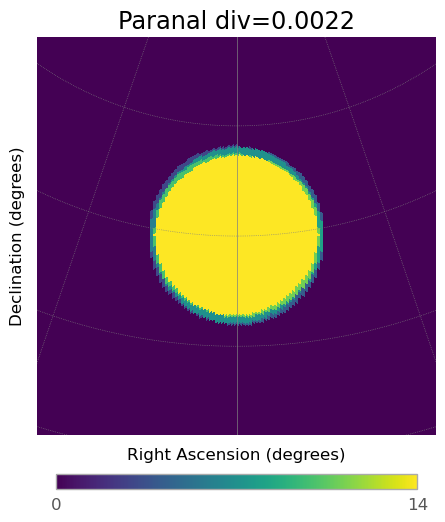

4it [00:00,  7.17it/s]
4it [00:00,  6.98it/s]


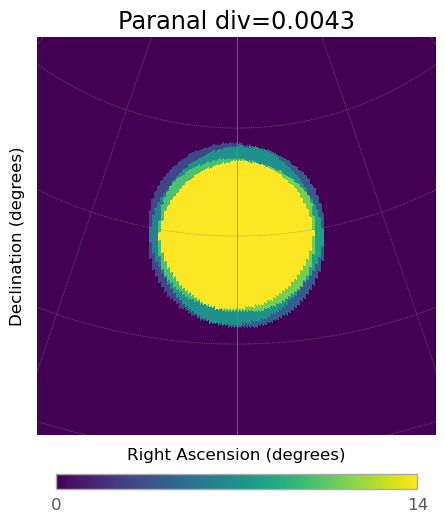

4it [00:00,  7.51it/s]
4it [00:00,  6.96it/s]


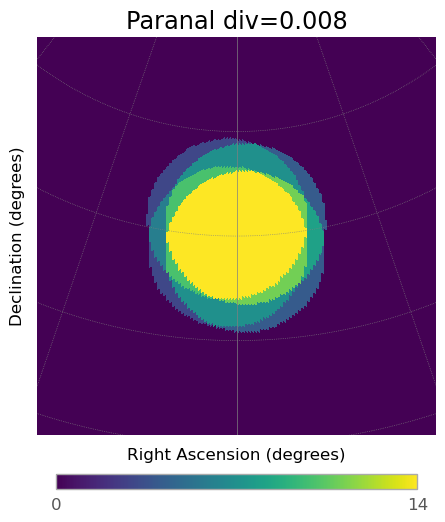

4it [00:00,  7.29it/s]
4it [00:00,  7.11it/s]


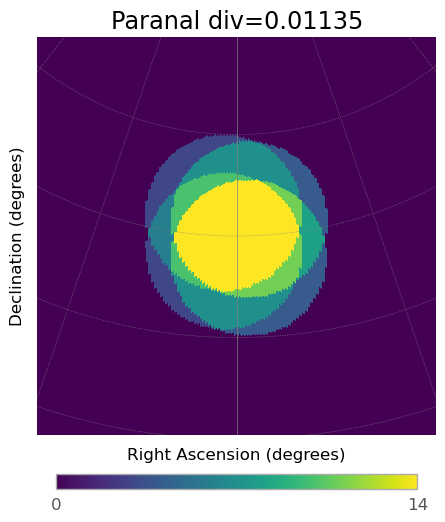

4it [00:00,  7.28it/s]
4it [00:00,  6.91it/s]


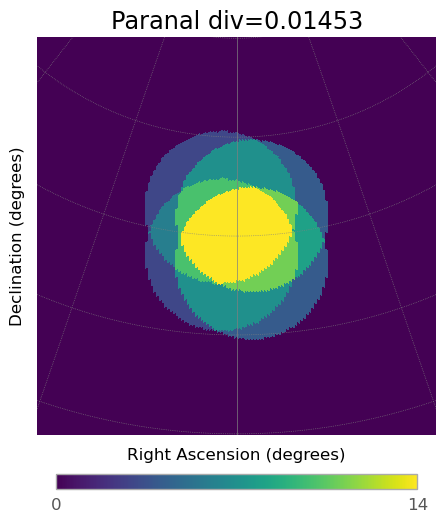

4it [00:00,  7.33it/s]
4it [00:00,  6.97it/s]


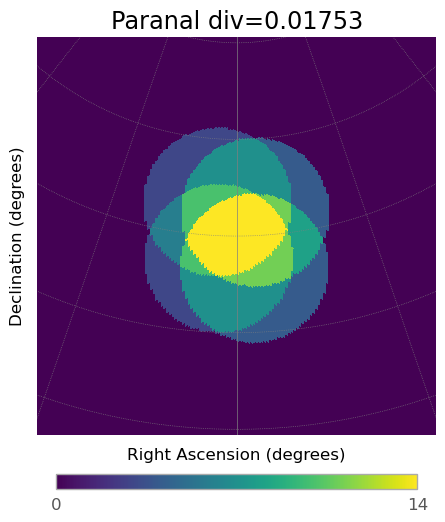

4it [00:00,  7.53it/s]
4it [00:00,  7.16it/s]


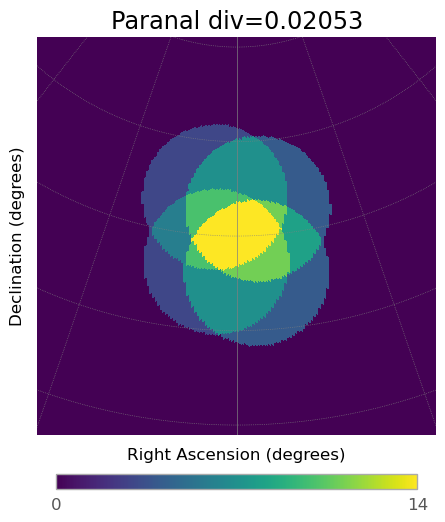

4it [00:00,  7.43it/s]
4it [00:00,  7.08it/s]


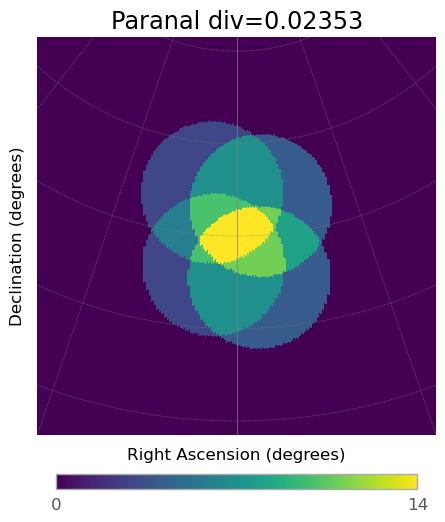

4it [00:00,  7.52it/s]
4it [00:00,  6.98it/s]


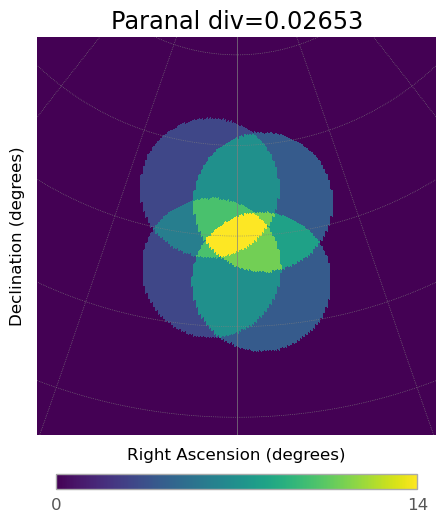

4it [00:00,  7.21it/s]
4it [00:00,  6.97it/s]


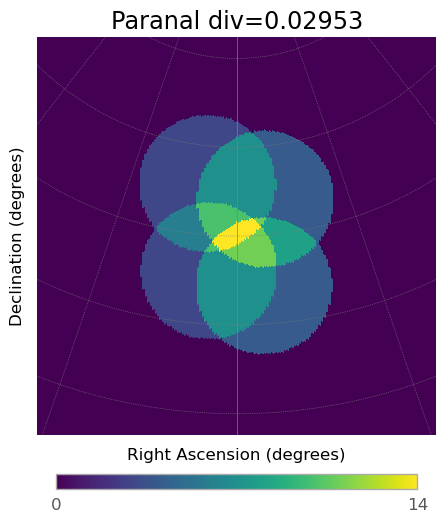

In [189]:
for divergence in chosen_divergences:
    array.divergent_pointing(div=divergence, az=0, alt=70)
    array.multiplicity_plot(number_of_telescopes_subarray_1)

14it [00:01,  7.38it/s]
14it [00:01,  7.20it/s]


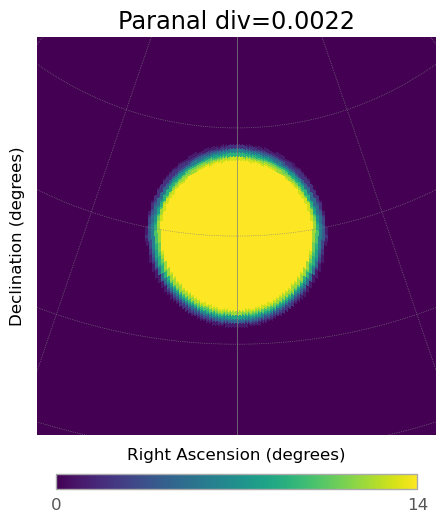

14it [00:01,  7.36it/s]
14it [00:02,  6.93it/s]


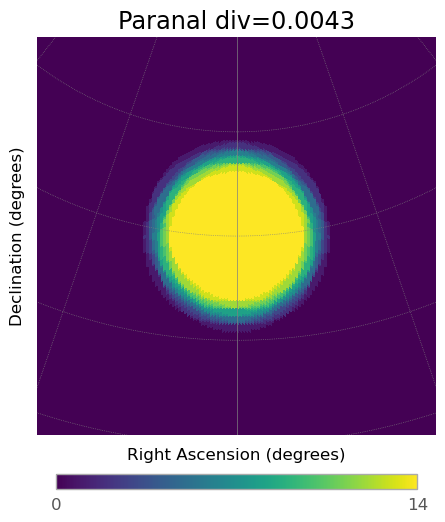

14it [00:01,  7.09it/s]
14it [00:01,  7.05it/s]


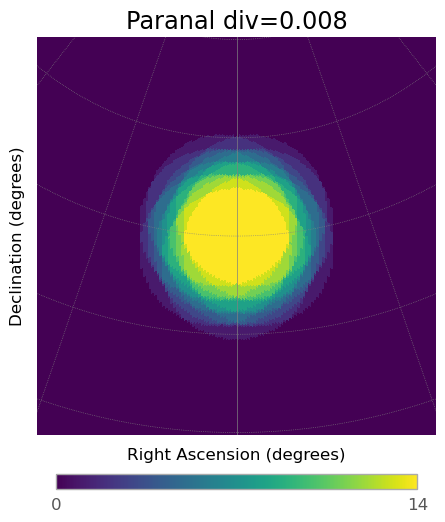

14it [00:02,  7.00it/s]
14it [00:01,  7.13it/s]


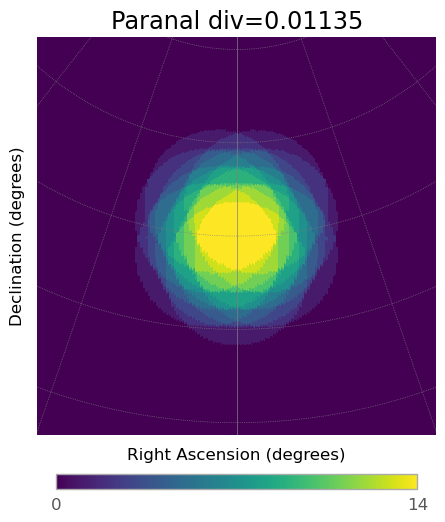

14it [00:01,  7.15it/s]
14it [00:01,  7.32it/s]


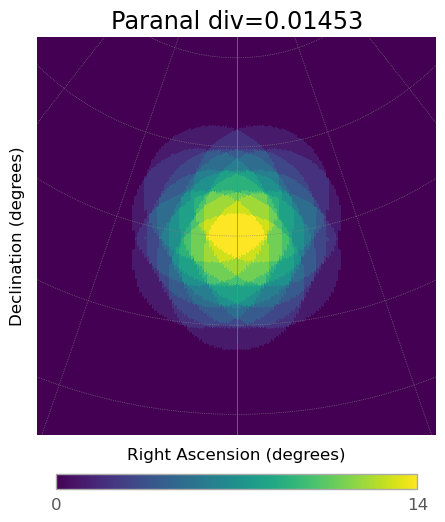

14it [00:01,  7.40it/s]
14it [00:01,  7.24it/s]


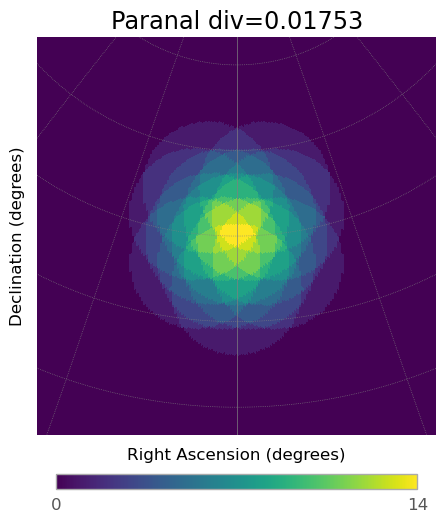

14it [00:01,  7.29it/s]
14it [00:02,  6.98it/s]


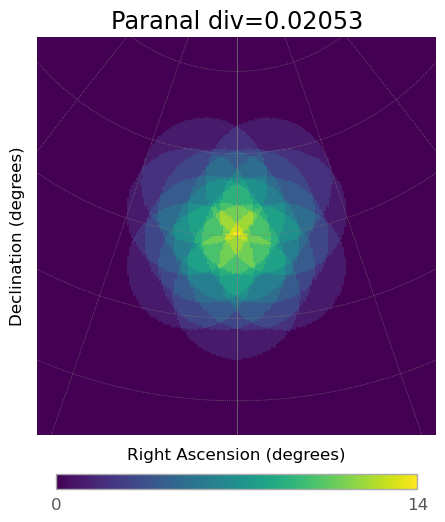

14it [00:01,  7.12it/s]
14it [00:02,  6.99it/s]


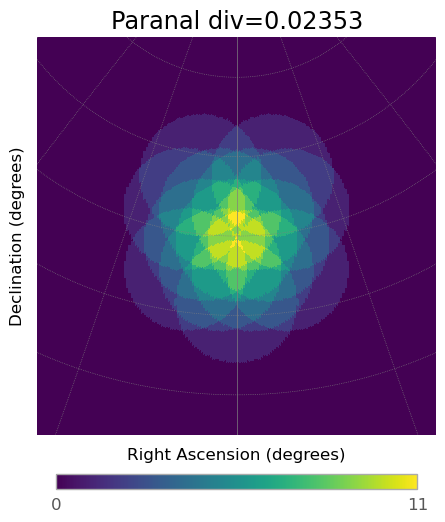

14it [00:01,  7.23it/s]
14it [00:01,  7.06it/s]


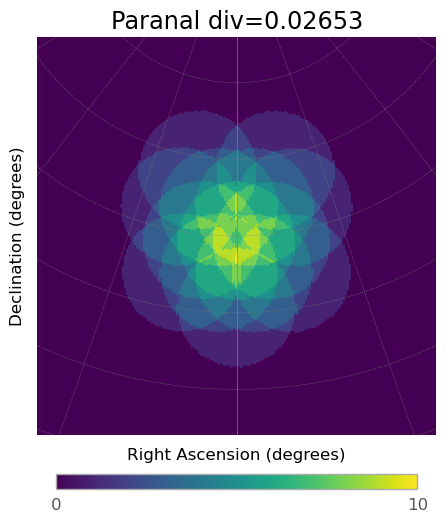

14it [00:01,  7.21it/s]
14it [00:02,  6.84it/s]


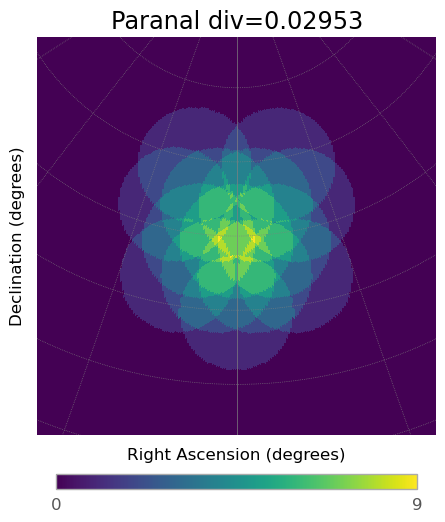

In [190]:
for divergence in chosen_divergences:
    full_array.divergent_pointing(div=divergence, az=0, alt=70)
    full_array.multiplicity_plot()


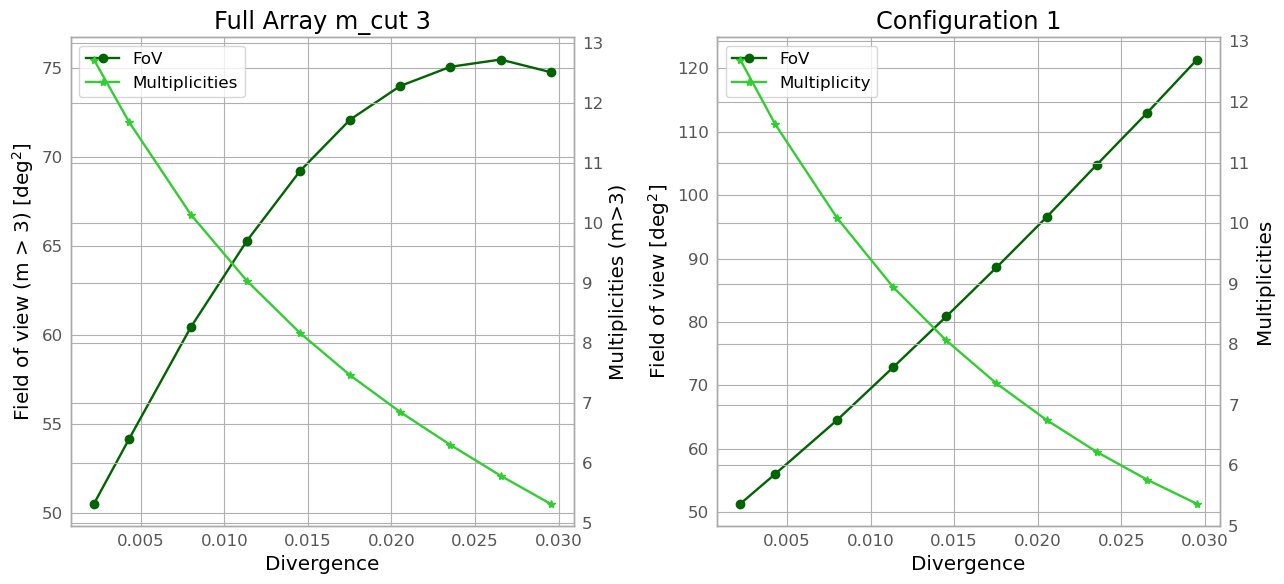

In [191]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6)) 
# Plot Full Array
# Full Array with m_cut = 3
l1=axes[0].plot(chosen_divergences, FoV_full_array, label='FoV', marker='o', color='darkgreen')
ax2 = axes[0].twinx()
l2=ax2.plot(chosen_divergences, multiplicity_full_array, label='Multiplicities',marker='*', color='limegreen')
axes[0].set_title('Full Array m_cut 3')
axes[0].set_xlabel('Divergence')
axes[0].set_ylabel('Field of view (m > 3) [deg$^2$]')
ax2.set_ylabel('Multiplicities (m>3)')
axeslegend = l1+l2
axes[0].legend(axeslegend, [l.get_label() for l in axeslegend])



#Plot the ones for subarray 1
l1=axes[1].plot(chosen_divergences, FoV_array_div_chosen, label='FoV',marker='o', color='darkgreen')
ax5=axes[1].twinx()
l2=ax5.plot(chosen_divergences, av_multiplicity_array_div_chosen, label='Multiplicity', marker='*', color='limegreen')
axes[1].set_title('Configuration 1')
axes[1].set_xlabel('Divergence')
axes[1].set_ylabel('Field of view [deg$^2$]')
ax5.set_ylabel('Multiplicities')
axeslegend = l1+l2
axes[1].legend(axeslegend, [l.get_label() for l in axeslegend])
#Plot the ones for subarray 2

# Adjust layout
plt.tight_layout()

plt.show()

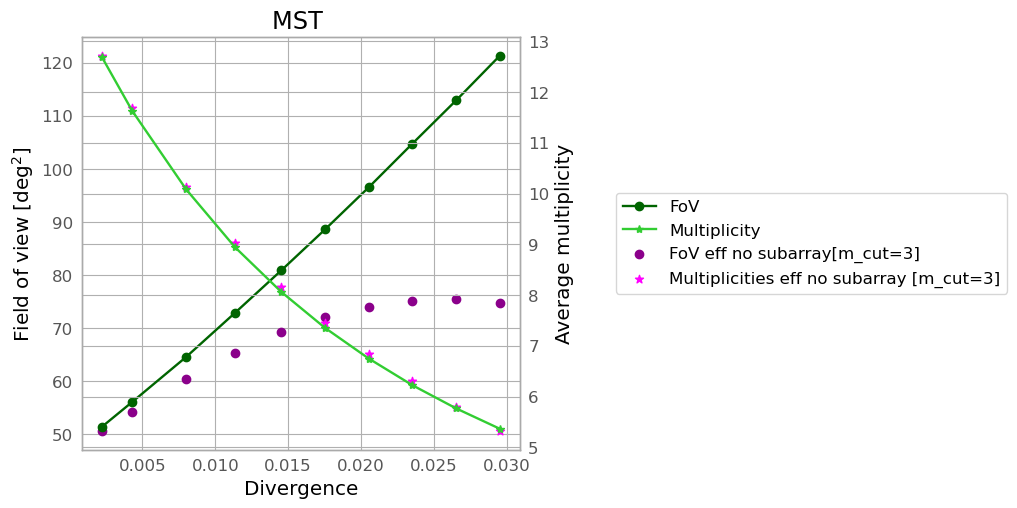

In [192]:
f, ax = plt.subplots(1, 1, figsize=(6,5))
p1 = ax.plot(chosen_divergences, FoV_array_div_chosen, label='FoV',marker='o', color='darkgreen')
p3=plt.scatter(chosen_divergences, FoV_full_array, label='FoV eff no subarray[m_cut=3]', marker='o', color='darkmagenta')
ax.set_xlabel('Divergence')
ax.set_ylabel('Field of view [deg$^2$]')

ax2 = ax.twinx()
p2 = ax2.plot(chosen_divergences, av_multiplicity_array_div_chosen, label='Multiplicity', marker='*', color='limegreen')
ax2.set_ylabel("Average multiplicity")
plt.tight_layout()
plt.title("MST ")

p4=plt.scatter(chosen_divergences, multiplicity_full_array, label='Multiplicities eff no subarray [m_cut=3]',marker='*', color='magenta')
ps = p1+p2+[p3]+[p4]
ax.legend(ps, [p.get_label() for p in ps], loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

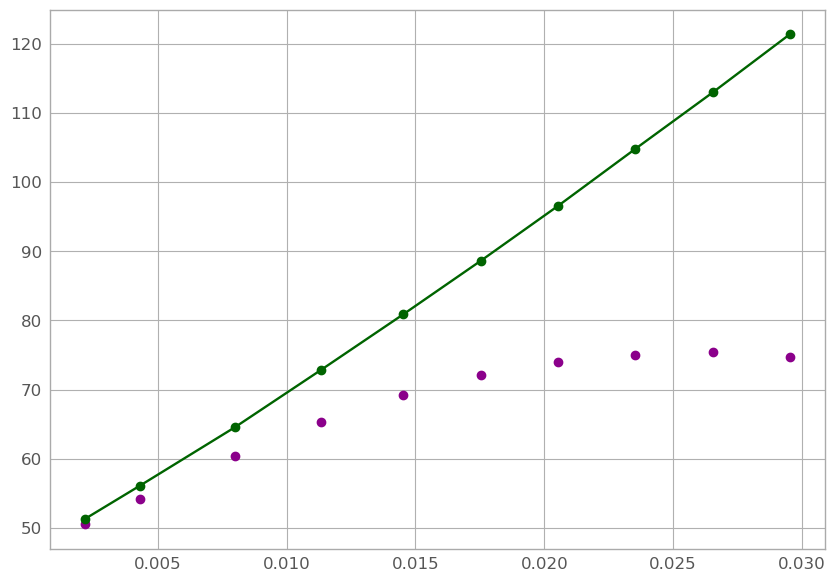

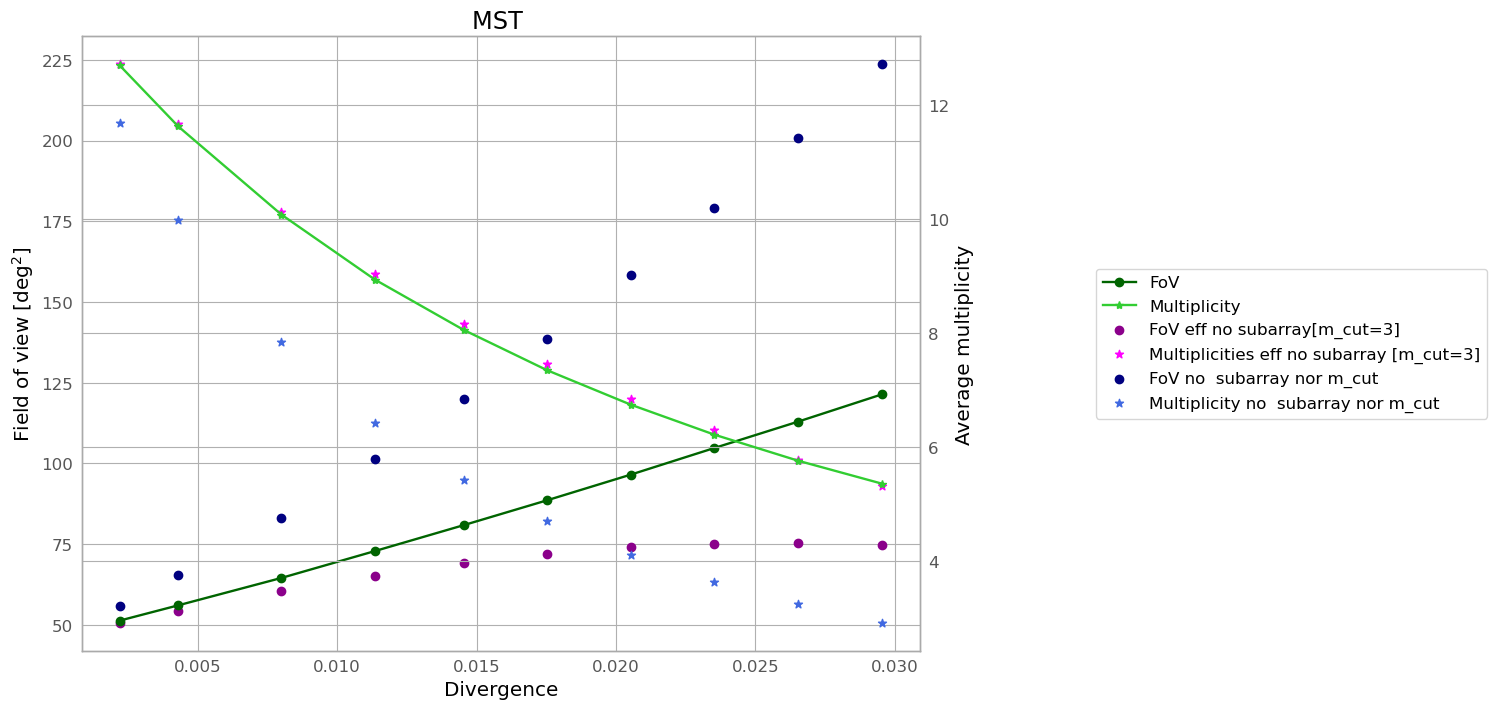

In [195]:
f, ax = plt.subplots(1, 1, figsize=(10,7))
p1 = ax.plot(chosen_divergences, FoV_array_div_chosen, label='FoV',marker='o', color='darkgreen')
p3=plt.scatter(chosen_divergences, FoV_full_array, label='FoV eff no subarray[m_cut=3]', marker='o', color='darkmagenta')
p5=plt.scatter(chosen_divergences, FoV_full_array_no_multiplicity_cut, label='FoV no  subarray nor m_cut', marker='o', color='navy')
ax.set_xlabel('Divergence')
ax.set_ylabel('Field of view [deg$^2$]')


ax2 = ax.twinx()
p2 = ax2.plot(chosen_divergences, av_multiplicity_array_div_chosen, label='Multiplicity', marker='*', color='limegreen')
ax2.set_ylabel("Average multiplicity")
plt.tight_layout()
plt.title("MST ")

p4=plt.scatter(chosen_divergences, multiplicity_full_array, label='Multiplicities eff no subarray [m_cut=3]',marker='*', color='magenta')
p6=plt.scatter(chosen_divergences, multiplicity_full_array_no_multiplicity_cut, label='Multiplicity no  subarray nor m_cut', marker='*', color='royalblue')
ps = p1+p2+[p3]+[p4] +[p5]+[p6]
ax.legend(ps, [p.get_label() for p in ps], loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

0


4it [00:00,  7.02it/s]
14it [00:01,  7.38it/s]
4it [00:00,  7.27it/s]
14it [00:01,  7.19it/s]


1


4it [00:00,  7.06it/s]
14it [00:01,  7.37it/s]
4it [00:00,  7.37it/s]
14it [00:01,  7.51it/s]


2


4it [00:00,  7.30it/s]
14it [00:01,  7.39it/s]
4it [00:00,  7.42it/s]
14it [00:01,  7.31it/s]


3


4it [00:00,  7.22it/s]
14it [00:01,  7.32it/s]
4it [00:00,  7.24it/s]
14it [00:01,  7.45it/s]


4


4it [00:00,  7.35it/s]
14it [00:01,  7.27it/s]
4it [00:00,  7.14it/s]
14it [00:01,  7.37it/s]


5


4it [00:00,  7.40it/s]
14it [00:01,  7.49it/s]
4it [00:00,  7.43it/s]
14it [00:01,  7.34it/s]


6


4it [00:00,  7.41it/s]
14it [00:01,  7.45it/s]
4it [00:00,  7.15it/s]
14it [00:01,  7.40it/s]


7


4it [00:00,  7.36it/s]
14it [00:01,  7.43it/s]
4it [00:00,  7.24it/s]
14it [00:01,  7.40it/s]


8


4it [00:00,  7.39it/s]
14it [00:01,  7.41it/s]
4it [00:00,  7.17it/s]
14it [00:01,  7.40it/s]


9


4it [00:00,  7.25it/s]
14it [00:01,  7.27it/s]
4it [00:00,  6.96it/s]
14it [00:01,  7.19it/s]


10


4it [00:00,  7.21it/s]
14it [00:01,  7.34it/s]
4it [00:00,  7.49it/s]
14it [00:01,  7.23it/s]


11


4it [00:00,  7.39it/s]
14it [00:01,  7.40it/s]
4it [00:00,  7.31it/s]
14it [00:01,  7.40it/s]


12


4it [00:00,  7.19it/s]
14it [00:01,  7.39it/s]
4it [00:00,  7.29it/s]
14it [00:01,  7.39it/s]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


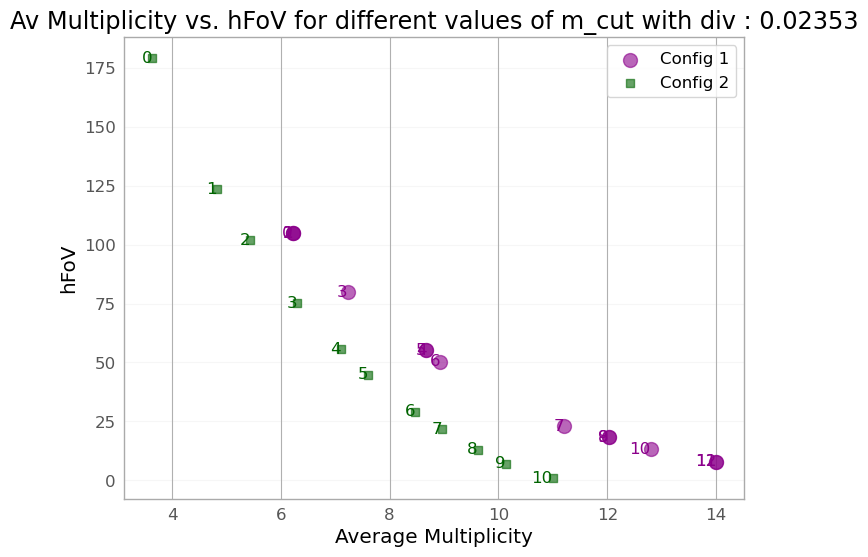

In [199]:
array.divergent_pointing(div=0.02353, az=0, alt=70)
full_array.divergent_pointing(div=0.02353, az=0, alt=70)
array.combination_bar_graph_av_mult(full_array,subarray_mult=number_of_telescopes_subarray_1)

0


4it [00:00,  6.88it/s]
14it [00:01,  7.24it/s]
4it [00:00,  7.25it/s]
14it [00:01,  7.25it/s]


1


4it [00:00,  7.25it/s]
14it [00:01,  7.26it/s]
4it [00:00,  7.23it/s]
14it [00:01,  7.25it/s]


2


4it [00:00,  7.27it/s]
14it [00:01,  7.29it/s]
4it [00:00,  7.34it/s]
14it [00:01,  7.31it/s]


3


4it [00:00,  7.29it/s]
14it [00:01,  7.31it/s]
4it [00:00,  7.06it/s]
14it [00:01,  7.25it/s]


4


4it [00:00,  7.22it/s]
14it [00:01,  7.25it/s]
4it [00:00,  7.36it/s]
14it [00:01,  7.42it/s]


5


4it [00:00,  7.28it/s]
14it [00:01,  7.32it/s]
4it [00:00,  7.44it/s]
14it [00:01,  7.34it/s]


6


4it [00:00,  7.29it/s]
14it [00:01,  7.21it/s]
4it [00:00,  7.30it/s]
14it [00:01,  7.36it/s]


7


4it [00:00,  7.40it/s]
14it [00:01,  7.33it/s]
4it [00:00,  7.22it/s]
14it [00:01,  7.20it/s]


8


4it [00:00,  6.79it/s]
14it [00:01,  7.25it/s]
4it [00:00,  7.19it/s]
14it [00:01,  7.32it/s]


9


4it [00:00,  7.25it/s]
14it [00:01,  7.33it/s]
4it [00:00,  7.01it/s]
14it [00:01,  7.31it/s]


10


4it [00:00,  6.81it/s]
14it [00:01,  7.28it/s]
4it [00:00,  7.06it/s]
14it [00:01,  7.27it/s]


11


4it [00:00,  7.24it/s]
14it [00:01,  7.21it/s]
4it [00:00,  7.02it/s]
14it [00:01,  7.34it/s]


12


4it [00:00,  6.88it/s]
14it [00:01,  7.23it/s]
4it [00:00,  7.24it/s]
14it [00:01,  7.23it/s]


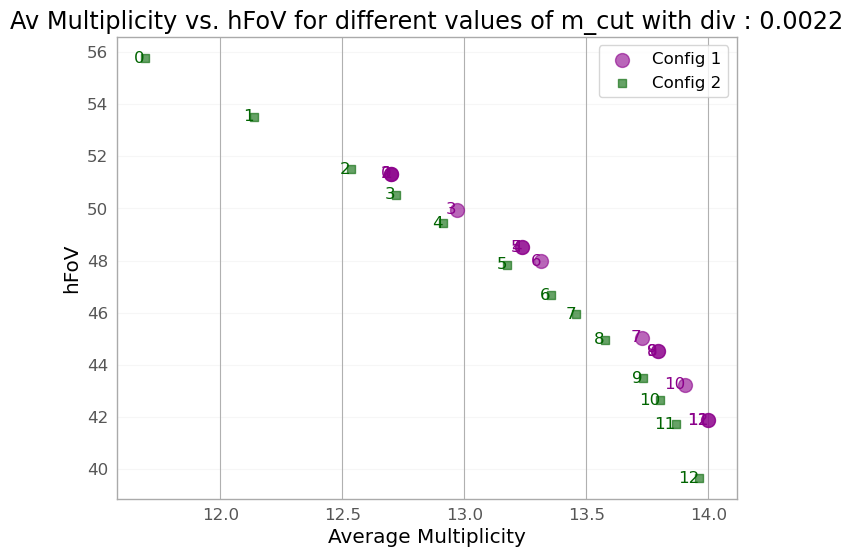

The divergence is0.0022
0


4it [00:00,  7.29it/s]
14it [00:01,  7.40it/s]
4it [00:00,  7.33it/s]
14it [00:01,  7.29it/s]


1


4it [00:00,  7.09it/s]
14it [00:01,  7.24it/s]
4it [00:00,  7.27it/s]
14it [00:01,  7.26it/s]


2


4it [00:00,  7.40it/s]
14it [00:01,  7.27it/s]
4it [00:00,  7.40it/s]
14it [00:01,  7.27it/s]


3


4it [00:00,  7.43it/s]
14it [00:01,  7.38it/s]
4it [00:00,  7.12it/s]
14it [00:01,  7.19it/s]


4


4it [00:00,  7.45it/s]
14it [00:01,  7.01it/s]
4it [00:00,  6.66it/s]
14it [00:01,  7.25it/s]


5


4it [00:00,  7.00it/s]
14it [00:01,  7.19it/s]
4it [00:00,  7.10it/s]
14it [00:01,  7.28it/s]


6


4it [00:00,  7.25it/s]
14it [00:01,  7.13it/s]
4it [00:00,  7.09it/s]
14it [00:01,  7.12it/s]


7


4it [00:00,  7.24it/s]
14it [00:01,  7.19it/s]
4it [00:00,  7.09it/s]
14it [00:01,  7.12it/s]


8


4it [00:00,  7.21it/s]
14it [00:01,  7.20it/s]
4it [00:00,  7.19it/s]
14it [00:01,  7.08it/s]


9


4it [00:00,  7.25it/s]
14it [00:01,  7.35it/s]
4it [00:00,  7.33it/s]
14it [00:01,  7.40it/s]


10


4it [00:00,  7.27it/s]
14it [00:01,  7.20it/s]
4it [00:00,  7.41it/s]
14it [00:01,  7.31it/s]


11


4it [00:00,  7.38it/s]
14it [00:01,  7.23it/s]
4it [00:00,  7.22it/s]
14it [00:01,  7.31it/s]


12


4it [00:00,  7.33it/s]
14it [00:01,  7.12it/s]
4it [00:00,  7.27it/s]
14it [00:01,  7.31it/s]


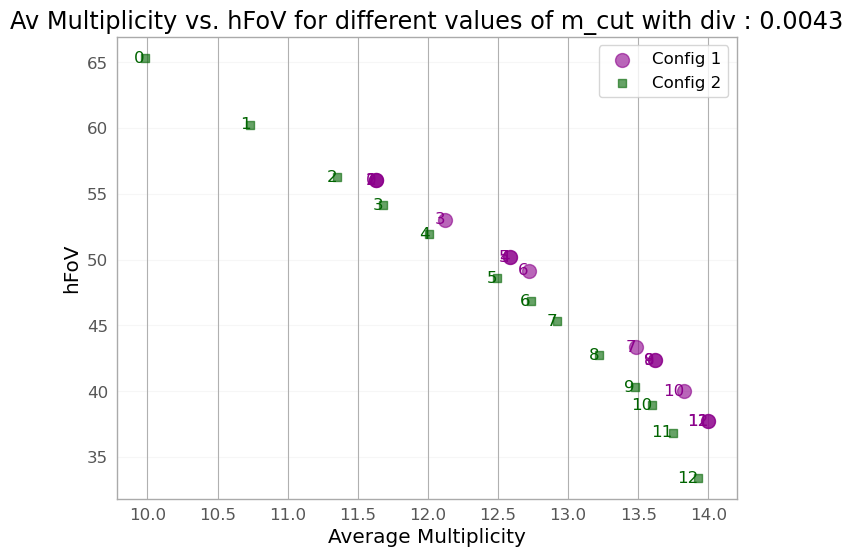

The divergence is0.0043
0


4it [00:00,  7.18it/s]
14it [00:01,  7.37it/s]
4it [00:00,  7.17it/s]
14it [00:01,  7.21it/s]


1


4it [00:00,  7.29it/s]
14it [00:01,  7.02it/s]
4it [00:00,  7.08it/s]
14it [00:01,  7.31it/s]


2


4it [00:00,  7.44it/s]
14it [00:01,  7.25it/s]
4it [00:00,  7.21it/s]
14it [00:01,  7.40it/s]


3


4it [00:00,  7.20it/s]
14it [00:01,  7.37it/s]
4it [00:00,  6.71it/s]
14it [00:01,  7.23it/s]


4


4it [00:00,  6.78it/s]
14it [00:01,  7.26it/s]
4it [00:00,  7.32it/s]
14it [00:01,  7.03it/s]


5


4it [00:00,  6.89it/s]
14it [00:01,  7.24it/s]
4it [00:00,  7.34it/s]
14it [00:01,  7.35it/s]


6


4it [00:00,  7.35it/s]
14it [00:01,  7.35it/s]
4it [00:00,  7.32it/s]
14it [00:01,  7.39it/s]


7


4it [00:00,  7.42it/s]
14it [00:01,  7.36it/s]
4it [00:00,  7.28it/s]
14it [00:01,  7.34it/s]


8


4it [00:00,  7.31it/s]
14it [00:01,  7.21it/s]
4it [00:00,  7.17it/s]
14it [00:01,  7.31it/s]


9


4it [00:00,  7.45it/s]
14it [00:01,  7.28it/s]
4it [00:00,  7.32it/s]
14it [00:01,  7.35it/s]


10


4it [00:00,  7.50it/s]
14it [00:01,  7.22it/s]
4it [00:00,  6.85it/s]
14it [00:01,  7.41it/s]


11


4it [00:00,  7.34it/s]
14it [00:01,  7.35it/s]
4it [00:00,  7.54it/s]
14it [00:01,  7.36it/s]


12


4it [00:00,  6.92it/s]
14it [00:02,  6.99it/s]
4it [00:00,  7.33it/s]
14it [00:01,  7.35it/s]


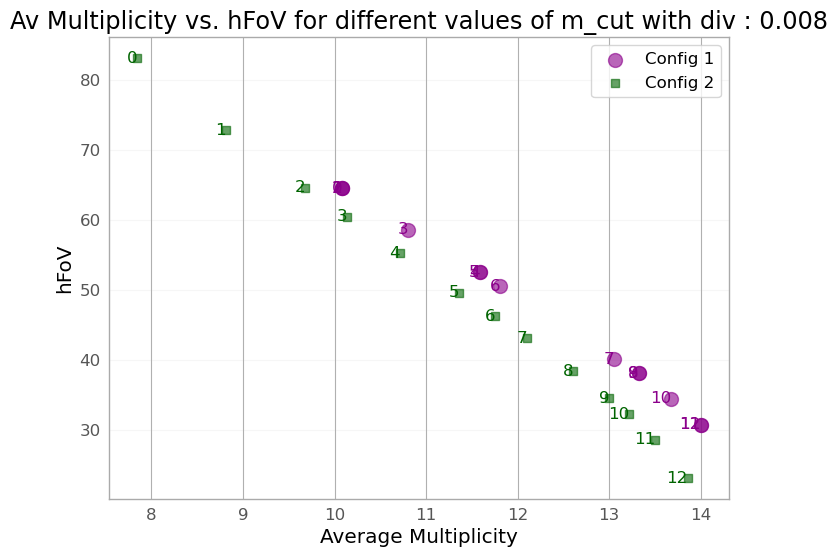

The divergence is0.008
0


4it [00:00,  7.41it/s]
14it [00:01,  7.24it/s]
4it [00:00,  7.27it/s]
14it [00:02,  6.96it/s]


1


4it [00:00,  6.87it/s]
14it [00:02,  6.68it/s]
4it [00:00,  7.23it/s]
14it [00:01,  7.30it/s]


2


4it [00:00,  7.28it/s]
14it [00:02,  6.95it/s]
4it [00:00,  6.84it/s]
14it [00:01,  7.06it/s]


3


4it [00:00,  7.35it/s]
14it [00:02,  6.95it/s]
4it [00:00,  7.34it/s]
14it [00:01,  7.34it/s]


4


4it [00:00,  7.30it/s]
14it [00:01,  7.13it/s]
4it [00:00,  6.96it/s]
14it [00:01,  7.30it/s]


5


4it [00:00,  7.32it/s]
14it [00:02,  6.96it/s]
4it [00:00,  6.71it/s]
14it [00:01,  7.23it/s]


6


4it [00:00,  7.28it/s]
14it [00:01,  7.01it/s]
4it [00:00,  7.17it/s]
14it [00:01,  7.23it/s]


7


4it [00:00,  7.20it/s]
14it [00:01,  7.32it/s]
4it [00:00,  7.36it/s]
14it [00:01,  7.37it/s]


8


4it [00:00,  7.32it/s]
14it [00:01,  7.26it/s]
4it [00:00,  6.85it/s]
14it [00:01,  7.27it/s]


9


4it [00:00,  7.25it/s]
14it [00:01,  7.35it/s]
4it [00:00,  7.20it/s]
14it [00:01,  7.25it/s]


10


4it [00:00,  7.20it/s]
14it [00:01,  7.17it/s]
4it [00:00,  7.33it/s]
14it [00:01,  7.13it/s]


11


4it [00:00,  7.28it/s]
14it [00:01,  7.13it/s]
4it [00:00,  7.40it/s]
14it [00:01,  7.18it/s]


12


4it [00:00,  7.35it/s]
14it [00:01,  7.08it/s]
4it [00:00,  7.38it/s]
14it [00:01,  7.29it/s]


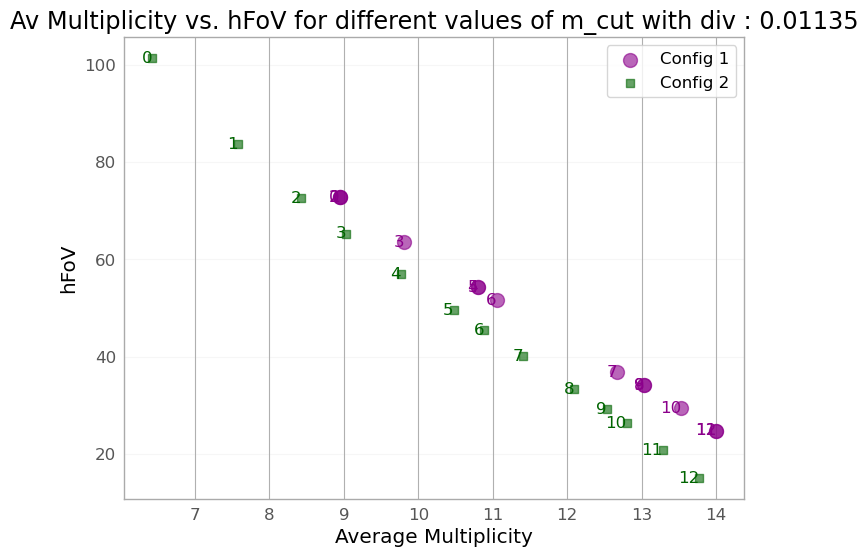

The divergence is0.01135
0


4it [00:00,  7.14it/s]
14it [00:01,  7.31it/s]
4it [00:00,  7.15it/s]
14it [00:01,  7.26it/s]


1


4it [00:00,  7.33it/s]
14it [00:01,  7.34it/s]
4it [00:00,  7.23it/s]
14it [00:01,  7.43it/s]


2


4it [00:00,  7.09it/s]
14it [00:01,  7.27it/s]
4it [00:00,  7.38it/s]
14it [00:01,  7.37it/s]


3


4it [00:00,  7.42it/s]
14it [00:01,  7.38it/s]
4it [00:00,  7.14it/s]
14it [00:01,  7.27it/s]


4


4it [00:00,  7.08it/s]
14it [00:01,  7.29it/s]
4it [00:00,  7.33it/s]
14it [00:01,  7.19it/s]


5


4it [00:00,  7.34it/s]
14it [00:01,  7.29it/s]
4it [00:00,  7.02it/s]
14it [00:01,  7.35it/s]


6


4it [00:00,  7.35it/s]
14it [00:01,  7.42it/s]
4it [00:00,  7.32it/s]
14it [00:01,  7.34it/s]


7


4it [00:00,  7.39it/s]
14it [00:01,  7.22it/s]
4it [00:00,  7.30it/s]
14it [00:01,  7.21it/s]


8


4it [00:00,  7.03it/s]
14it [00:01,  7.34it/s]
4it [00:00,  7.10it/s]
14it [00:01,  7.31it/s]


9


4it [00:00,  7.21it/s]
14it [00:01,  7.27it/s]
4it [00:00,  7.10it/s]
14it [00:01,  7.10it/s]


10


4it [00:00,  7.24it/s]
14it [00:01,  7.17it/s]
4it [00:00,  7.30it/s]
14it [00:01,  7.30it/s]


11


4it [00:00,  7.25it/s]
14it [00:01,  7.29it/s]
4it [00:00,  7.38it/s]
14it [00:01,  7.31it/s]


12


4it [00:00,  7.39it/s]
14it [00:01,  7.28it/s]
4it [00:00,  7.19it/s]
14it [00:01,  7.26it/s]


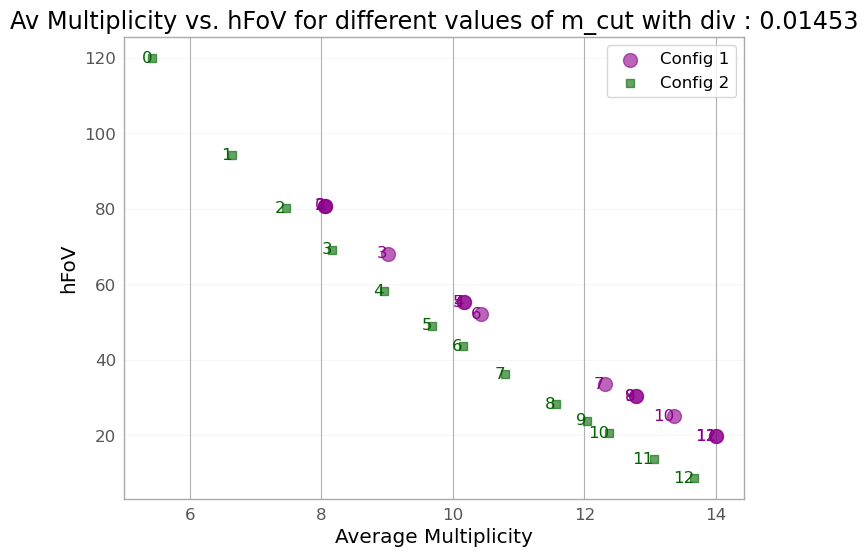

The divergence is0.01453
0


4it [00:00,  7.13it/s]
14it [00:01,  7.35it/s]
4it [00:00,  6.91it/s]
14it [00:01,  7.27it/s]


1


4it [00:00,  7.19it/s]
14it [00:01,  7.36it/s]
4it [00:00,  7.27it/s]
14it [00:01,  7.29it/s]


2


4it [00:00,  7.34it/s]
14it [00:01,  7.22it/s]
4it [00:00,  7.13it/s]
14it [00:01,  7.31it/s]


3


4it [00:00,  7.29it/s]
14it [00:01,  7.23it/s]
4it [00:00,  7.33it/s]
14it [00:01,  7.31it/s]


4


4it [00:00,  7.05it/s]
14it [00:01,  7.10it/s]
4it [00:00,  7.16it/s]
14it [00:01,  7.23it/s]


5


4it [00:00,  7.38it/s]
14it [00:01,  7.25it/s]
4it [00:00,  7.10it/s]
14it [00:02,  6.97it/s]


6


4it [00:00,  6.67it/s]
14it [00:02,  6.91it/s]
4it [00:00,  7.08it/s]
14it [00:02,  6.68it/s]


7


4it [00:00,  7.17it/s]
14it [00:01,  7.09it/s]
4it [00:00,  6.61it/s]
14it [00:01,  7.28it/s]


8


4it [00:00,  7.28it/s]
14it [00:01,  7.20it/s]
4it [00:00,  7.12it/s]
14it [00:01,  7.25it/s]


9


4it [00:00,  7.19it/s]
14it [00:01,  7.33it/s]
4it [00:00,  7.35it/s]
14it [00:01,  7.23it/s]


10


4it [00:00,  7.29it/s]
14it [00:01,  7.23it/s]
4it [00:00,  6.50it/s]
14it [00:01,  7.25it/s]


11


4it [00:00,  6.58it/s]
14it [00:01,  7.15it/s]
4it [00:00,  7.15it/s]
14it [00:01,  7.11it/s]


12


4it [00:00,  7.22it/s]
14it [00:01,  7.28it/s]
4it [00:00,  7.20it/s]
14it [00:01,  7.11it/s]


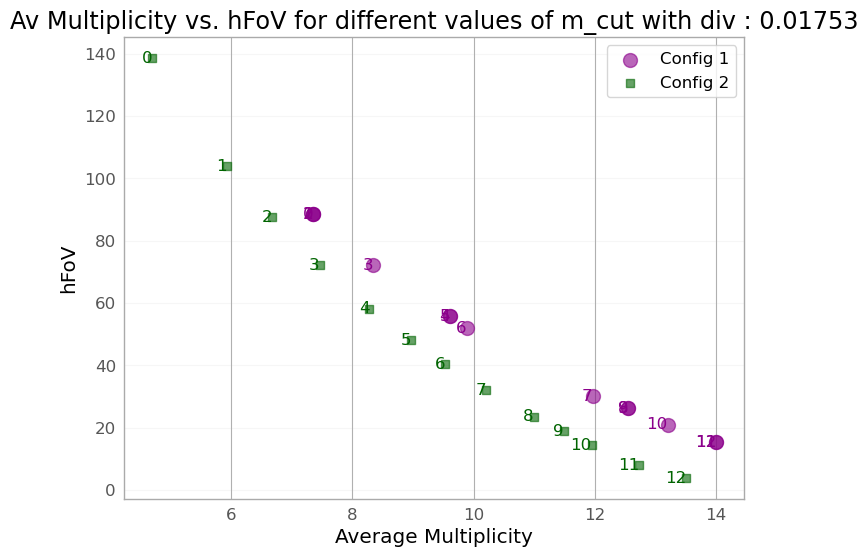

The divergence is0.01753
0


4it [00:00,  6.70it/s]
14it [00:01,  7.22it/s]
4it [00:00,  7.23it/s]
14it [00:02,  6.92it/s]


1


4it [00:00,  6.85it/s]
14it [00:01,  7.13it/s]
4it [00:00,  7.45it/s]
14it [00:01,  7.35it/s]


2


4it [00:00,  7.43it/s]
14it [00:01,  7.34it/s]
4it [00:00,  6.68it/s]
14it [00:02,  6.73it/s]


3


4it [00:00,  6.82it/s]
14it [00:01,  7.09it/s]
4it [00:00,  6.25it/s]
14it [00:01,  7.05it/s]


4


4it [00:00,  7.24it/s]
14it [00:01,  7.14it/s]
4it [00:00,  6.76it/s]
14it [00:02,  6.48it/s]


5


4it [00:00,  7.15it/s]
14it [00:02,  6.97it/s]
4it [00:00,  7.23it/s]
14it [00:01,  7.25it/s]


6


4it [00:00,  7.35it/s]
14it [00:01,  7.31it/s]
4it [00:00,  7.08it/s]
14it [00:01,  7.05it/s]


7


4it [00:00,  6.82it/s]
14it [00:01,  7.20it/s]
4it [00:00,  7.21it/s]
14it [00:01,  7.10it/s]


8


4it [00:00,  7.11it/s]
14it [00:01,  7.25it/s]
4it [00:00,  6.95it/s]
14it [00:01,  7.19it/s]


9


4it [00:00,  6.90it/s]
14it [00:01,  7.05it/s]
4it [00:00,  7.29it/s]
14it [00:01,  7.19it/s]


10


4it [00:00,  7.15it/s]
14it [00:01,  7.25it/s]
4it [00:00,  7.35it/s]
14it [00:01,  7.41it/s]


11


4it [00:00,  7.24it/s]
14it [00:01,  7.19it/s]
4it [00:00,  6.88it/s]
14it [00:01,  7.21it/s]


12


4it [00:00,  7.21it/s]
14it [00:01,  7.39it/s]
4it [00:00,  7.19it/s]
14it [00:01,  7.32it/s]


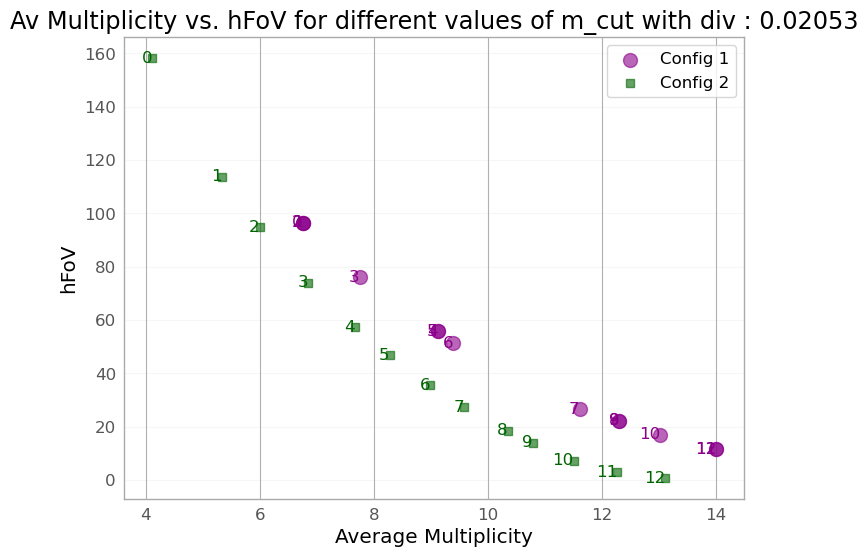

The divergence is0.02053
0


4it [00:00,  7.07it/s]
14it [00:01,  7.23it/s]
4it [00:00,  7.29it/s]
14it [00:01,  7.41it/s]


1


4it [00:00,  7.28it/s]
14it [00:01,  7.37it/s]
4it [00:00,  7.39it/s]
14it [00:01,  7.33it/s]


2


4it [00:00,  7.35it/s]
14it [00:01,  7.21it/s]
4it [00:00,  7.27it/s]
14it [00:01,  7.34it/s]


3


4it [00:00,  7.24it/s]
14it [00:01,  7.45it/s]
4it [00:00,  7.20it/s]
14it [00:01,  7.35it/s]


4


4it [00:00,  7.32it/s]
14it [00:01,  7.36it/s]
4it [00:00,  7.46it/s]
14it [00:01,  7.44it/s]


5


4it [00:00,  7.33it/s]
14it [00:01,  7.38it/s]
4it [00:00,  7.33it/s]
14it [00:01,  7.43it/s]


6


4it [00:00,  7.43it/s]
14it [00:01,  7.23it/s]
4it [00:00,  7.43it/s]
14it [00:01,  7.36it/s]


7


4it [00:00,  7.25it/s]
14it [00:01,  7.35it/s]
4it [00:00,  7.38it/s]
14it [00:01,  7.39it/s]


8


4it [00:00,  7.13it/s]
14it [00:01,  7.39it/s]
4it [00:00,  6.59it/s]
14it [00:01,  7.26it/s]


9


4it [00:00,  7.27it/s]
14it [00:01,  7.48it/s]
4it [00:00,  7.37it/s]
14it [00:01,  7.34it/s]


10


4it [00:00,  7.34it/s]
14it [00:01,  7.38it/s]
4it [00:00,  7.36it/s]
14it [00:01,  7.34it/s]


11


4it [00:00,  7.42it/s]
14it [00:01,  7.29it/s]
4it [00:00,  7.27it/s]
14it [00:01,  7.09it/s]


12


4it [00:00,  7.42it/s]
14it [00:01,  7.37it/s]
4it [00:00,  7.26it/s]
14it [00:01,  7.19it/s]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


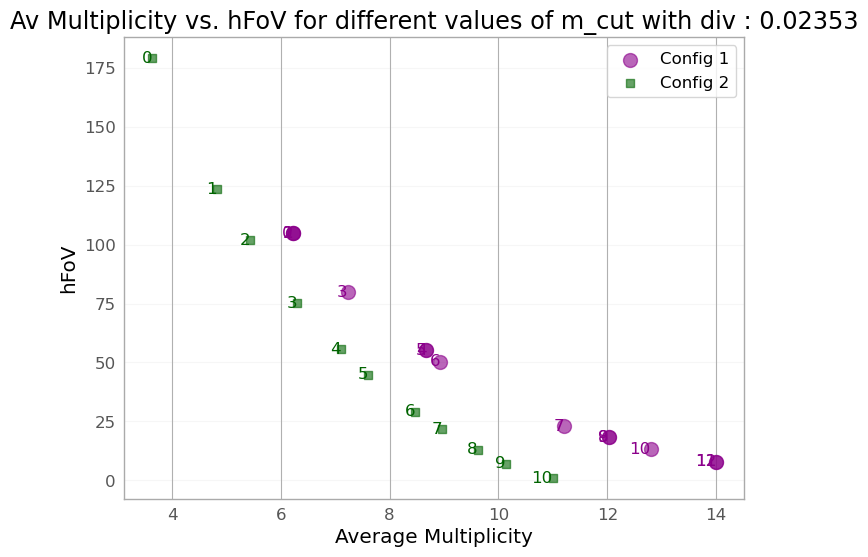

The divergence is0.02353
0


4it [00:00,  7.11it/s]
14it [00:01,  7.20it/s]
4it [00:00,  7.41it/s]
14it [00:01,  7.38it/s]


1


4it [00:00,  7.23it/s]
14it [00:02,  6.02it/s]
4it [00:00,  6.77it/s]
14it [00:02,  5.90it/s]


2


4it [00:00,  6.90it/s]
14it [00:01,  7.22it/s]
4it [00:00,  7.26it/s]
14it [00:01,  7.02it/s]


3


4it [00:00,  6.97it/s]
14it [00:02,  6.93it/s]
4it [00:00,  7.34it/s]
14it [00:01,  7.41it/s]


4


4it [00:00,  7.37it/s]
14it [00:02,  6.30it/s]
4it [00:00,  6.68it/s]
14it [00:02,  6.91it/s]


5


4it [00:00,  7.08it/s]
14it [00:01,  7.15it/s]
4it [00:00,  5.64it/s]
14it [00:01,  7.21it/s]


6


4it [00:00,  7.03it/s]
14it [00:01,  7.14it/s]
4it [00:00,  7.39it/s]
14it [00:01,  7.32it/s]


7


4it [00:00,  7.25it/s]
14it [00:01,  7.37it/s]
4it [00:00,  6.90it/s]
14it [00:01,  7.09it/s]


8


4it [00:00,  6.45it/s]
14it [00:01,  7.16it/s]
4it [00:00,  6.98it/s]
14it [00:01,  7.34it/s]


9


4it [00:00,  7.41it/s]
14it [00:02,  5.96it/s]
4it [00:00,  7.27it/s]
14it [00:01,  7.36it/s]


10


4it [00:00,  6.96it/s]
14it [01:38,  7.04s/it]
4it [00:00,  6.78it/s]
14it [00:01,  7.23it/s]


11


4it [00:00,  7.24it/s]
14it [00:01,  7.25it/s]
4it [00:00,  7.26it/s]
14it [00:01,  7.07it/s]


12


4it [00:00,  5.05it/s]
14it [00:02,  6.82it/s]
4it [00:00,  7.12it/s]
14it [00:01,  7.37it/s]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


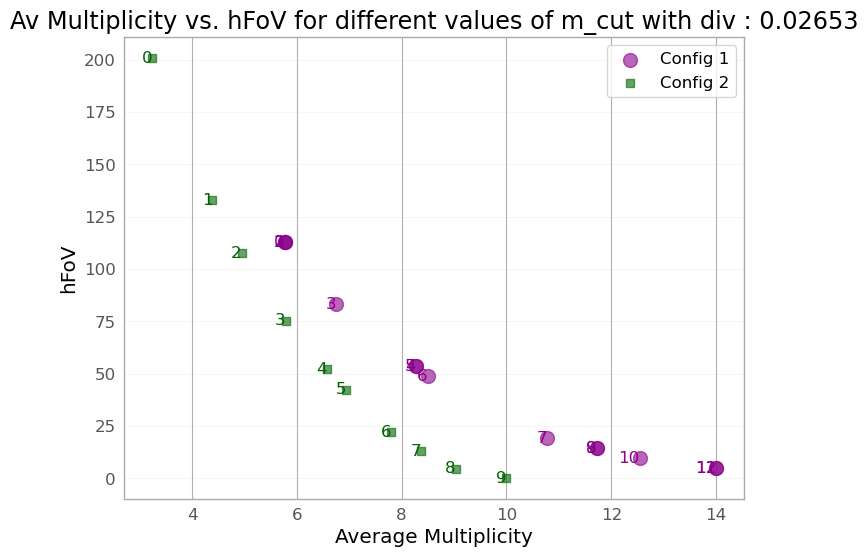

The divergence is0.02653
0


4it [00:00,  7.44it/s]
14it [00:01,  7.35it/s]
4it [00:00,  7.41it/s]
14it [00:01,  7.26it/s]


1


4it [00:00,  7.00it/s]
14it [00:02,  6.92it/s]
4it [00:00,  6.82it/s]
14it [00:01,  7.20it/s]


2


4it [00:00,  7.02it/s]
14it [00:01,  7.30it/s]
4it [00:00,  7.44it/s]
14it [01:28,  6.34s/it]


3


4it [00:00,  6.98it/s]
14it [00:01,  7.23it/s]
4it [00:00,  7.41it/s]
14it [00:01,  7.35it/s]


4


4it [00:00,  7.55it/s]
14it [00:01,  7.50it/s]
4it [00:00,  7.59it/s]
14it [00:01,  7.48it/s]


5


4it [00:53, 13.30s/it]
14it [00:01,  7.43it/s]
4it [00:00,  7.47it/s]
14it [00:01,  7.41it/s]


6


4it [00:00,  6.97it/s]
14it [00:01,  7.25it/s]
4it [00:00,  7.40it/s]
14it [00:01,  7.42it/s]


7


4it [00:00,  7.37it/s]
14it [00:51,  3.71s/it]
4it [00:00,  6.43it/s]
14it [00:02,  6.75it/s]


8


4it [00:00,  7.53it/s]
14it [00:01,  7.47it/s]
4it [00:00,  7.49it/s]
14it [00:01,  7.47it/s]


9


4it [00:00,  7.54it/s]
14it [00:01,  7.57it/s]
4it [00:00,  7.57it/s]
14it [00:01,  7.51it/s]


10


4it [00:00,  7.59it/s]
14it [00:24,  1.76s/it]
4it [00:00,  7.54it/s]
14it [00:01,  7.47it/s]


11


4it [00:00,  7.59it/s]
14it [00:01,  7.54it/s]
4it [00:00,  7.24it/s]
14it [00:01,  7.53it/s]


12


4it [00:00,  7.60it/s]
14it [15:54, 68.20s/it] 
4it [00:00,  7.55it/s]
14it [00:01,  7.61it/s]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


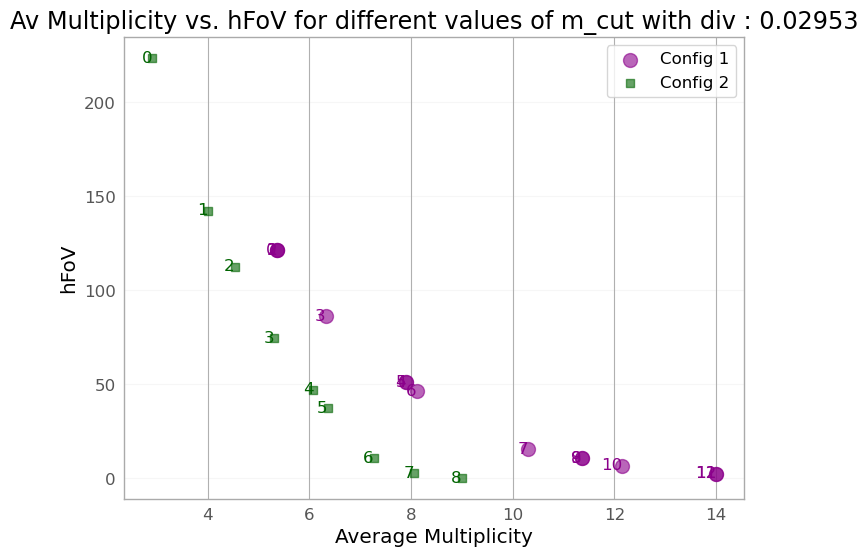

The divergence is0.02953


In [197]:
for divergence in chosen_divergences:
    array.divergent_pointing(div=divergence, az=0, alt=70)
    full_array.divergent_pointing(div=divergence, az=0, alt=70)
    array.combination_bar_graph_av_mult(full_array,subarray_mult=number_of_telescopes_subarray_1)
    print(f"The divergence is{divergence}")